In [1]:
import os, io
from pathlib import Path
import math
from collections import defaultdict, namedtuple, Counter, deque
from heapq import heapify, heappush, heappop
from itertools import chain
from dataclasses import dataclass, field
import itertools
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp
import operator

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import convolve2d
from numba import jit

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [3]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
hdv_db_con = sqlite3.connect(get_full_db_file_name(config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 124 ms, sys: 70.9 ms, total: 194 ms
Wall time: 194 ms


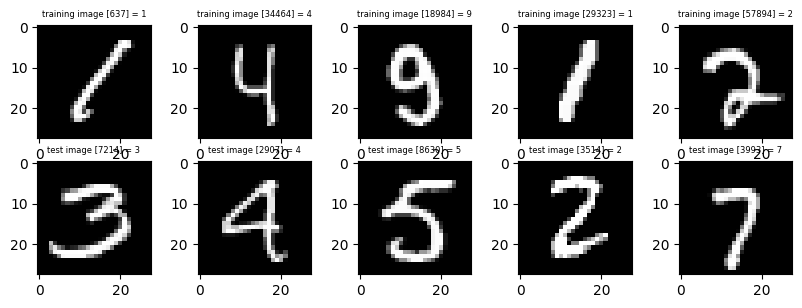

In [6]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Sequencing test

In [7]:
%run sequencing_sp2.ipynb


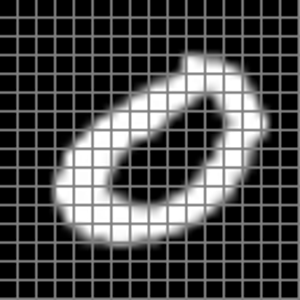
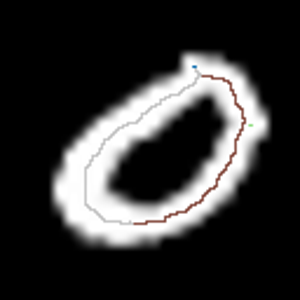
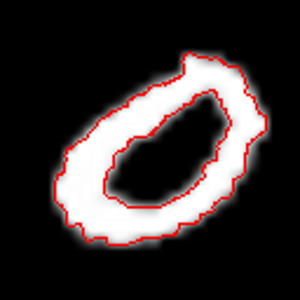
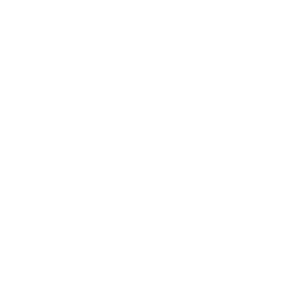
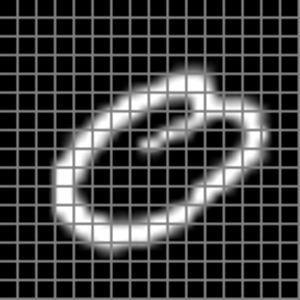
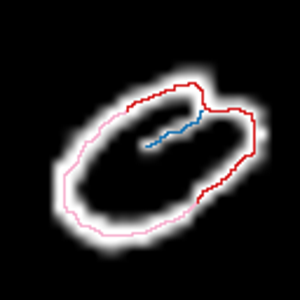
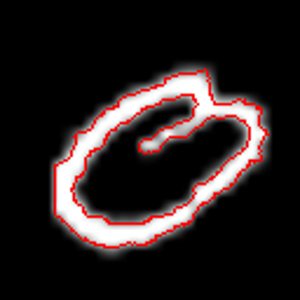
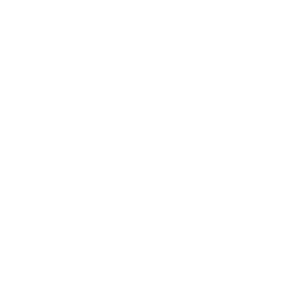
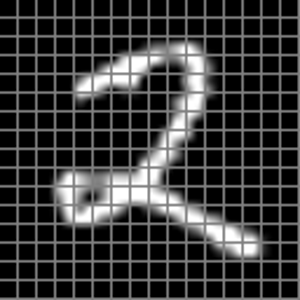
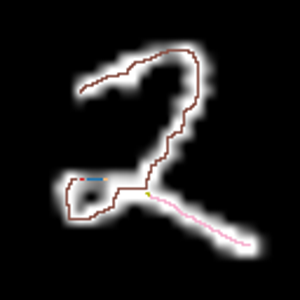
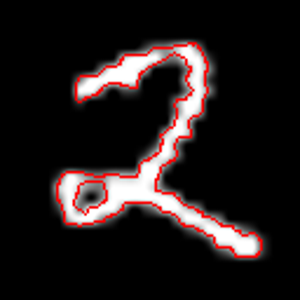
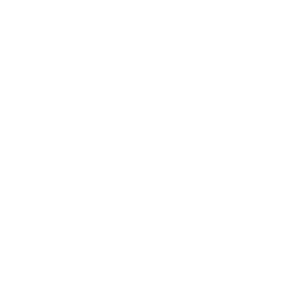

In [8]:
# %%time
image_indices = RNG.choice(len(x_train), 10)
image_indices = [22657, 24476, 29171]
# image_indices = [31838]
# image_indices = [55174]
# 45917 - то ли 9, то ли что. Вообще непонятно - всё размыто
# 1199 (2) - 50% не разобрали
# 1946 (7) - 50% не разобрали
# 26405 (9) - 30% не разобрали
# 12627 (8) - 50% не разобрали
# 31838 (5)
# 9634 (0) - нолик с точкой
images = []
captions = []

for image_index in image_indices:
    with Image.frombytes('L', size=(28, 28), data=x_train[image_index]) as img:
        img = img.resize((config.sample_size, config.sample_size))
        images.append(np.array(img).ravel())
        captions.append(f'{image_index}, {y_train[image_index]}')

images_matrix = xp_array_to_gpu(np.vstack([images]))
sense_vectors = sense_images(images_matrix)
assert sense_vectors.shape[0] == len(images)
seq_contexts = []

for sense_vector in sense_vectors:
    seq_context = parse_sense_vector(sense_vector)
    seq_context = get_outer_grooves(seq_context)
    seq_context = get_inner_grooves(seq_context)
    seq_context = get_outer_raw_sequences(seq_context)
    seq_context = get_outer_sequences(seq_context)
    seq_context = get_inner_raw_sequences(seq_context)
    seq_context = get_inner_sequences(seq_context)
    seq_contexts.append(seq_context)

# Outer sequences
oseq_images = []
oseq_captions = []
oseq_simpl_images = []
oseq_simpl_captions = []

for image, seq_context in zip(images, seq_contexts):
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image)
    image_pil = image_pil.convert('RGB')
    oseq_images.append(image_pil)
    draw = ImageDraw.Draw(image_pil)
    full_pts_count = 0

    for seq in seq_context.outer_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:] + seq[:1]):
            si_from = seq_context.outer_si_ind_dict[si_ind_from]
            si_to = seq_context.outer_si_ind_dict[si_ind_to]
            pt_from = si_from.x, si_from.y
            pt_to = si_to.x, si_to.y
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            full_pts_count += 1

    oseq_captions.append(f'{full_pts_count} pts')

    # image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image)
    # image_pil = image_pil.convert('RGB')
    # oseq_simpl_images.append(image_pil)
    # draw = ImageDraw.Draw(image_pil)
    # simpl_pts_count = 0

    # for seq in sequences_simplified:
    #     for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
    #         pt_from = si_from.x, si_from.y
    #         pt_to = si_to.x, si_to.y
    #         draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

    #         draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
    #         normal_vec = si_from.normal_vec
    #         draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * 5, pt_from[1] + normal_vec.imag * 5], width=1, fill='red')

    #         draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
    #         normal_vec = si_to.normal_vec
    #         draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * 5, pt_to[1] + normal_vec.imag * 5], width=1, fill='red')
    #         simpl_pts_count += 1

    # oseq_simpl_captions.append(f'{simpl_pts_count} pts ({simpl_pts_count / full_pts_count * 100:.0f}%)')

# Innser sequences
iseq_images = []
iseq_captions = []

for image, seq_context in zip(images, seq_contexts):
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image)
    image_pil = image_pil.convert('RGB')
    iseq_images.append(image_pil)
    draw = ImageDraw.Draw(image_pil)
    color_map = mpl.colormaps['tab20']

    for seq_i, seq in enumerate(seq_context.inner_sequences):
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = seq_context.inner_si_ind_dict[si_ind_from]
            si_to = seq_context.inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x, si_from.y
            pt_to = si_to.x, si_to.y
            color = color_map(seq_i / len(seq_context.inner_sequences), bytes=True)
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=color)

    iseq_captions.append(f'{len(seq_context.inner_sequences)} inner seqs')

empty_image = Image.new('L', size=(1,1), color='white')
all_images = itertools.chain.from_iterable(itertools.zip_longest(map(lambda i: lay_grid(matrix_to_image(i), 8), images), iseq_images, oseq_images, oseq_simpl_images, fillvalue=empty_image))
all_images = list(map(lambda i: i.resize((300, 300)), all_images))
all_captions = list(itertools.chain.from_iterable(itertools.zip_longest(captions, iseq_captions, oseq_captions, oseq_simpl_captions, fillvalue='')))
display_images_grid(all_images, captions=all_captions, col_count=4)

# Spare parts

## Sensor

In [191]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE ** 2

SENSORS_COUNT = config.sensors_count
SENSORS_COUNT_ROOT = int(np.sqrt(SENSORS_COUNT))
assert SENSORS_COUNT_ROOT ** 2 == SENSORS_COUNT
assert SENSORS_COUNT_ROOT > 1


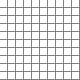
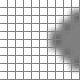
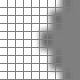
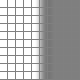
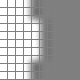
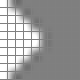
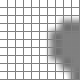
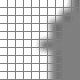
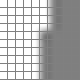
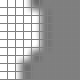
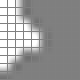
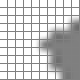
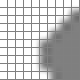
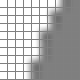
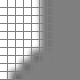
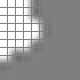
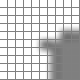
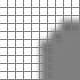
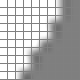
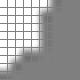

In [192]:
SENSOR_STATES_INFO = defaultdict(list)
SENSOR_STATES_IMG = []
sz = SENSOR_RECEPTIVE_FIELD_SIZE
captions = []

assert config.encoding_type == 'sequence'

angle_step = 10 # degrees
angles = list(range(0, 360, angle_step)) + [45 * 1, 45 * 3, 45 * 5, 45 * 7]
angles = sorted(angles)
# sweeps = [50, 90, 130, 180, 230, 270, 310] # for receptive field size = 8 more finer sweeps make little sense 
sweeps = [90, 130, 180, 230, 270] # for receptive field size = 8 more finer sweeps make little sense 

for angle in angles:
    if angle == 0:
        # add uber sensor state which will respond to completely illuminated patch
        white_canvas = Image.new('L', (sz, sz), color=255)
        captions.append(f'ang={angle}, UBER')
        SENSOR_STATES_IMG.append(white_canvas)
        SENSOR_STATES_INFO['normal'].append(angle)
        SENSOR_STATES_INFO['sweep'].append(0)
        SENSOR_STATES_INFO['normal_vec'].append(0j)
        SENSOR_STATES_INFO['sweep_vec'].append(0j)
        SENSOR_STATES_INFO['sweep1_vec'].append(0j)
        SENSOR_STATES_INFO['sweep2_vec'].append(0j)
    
    for sweep in sweeps:
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        draw.rectangle([0, 0, sz, sz], fill=127, outline=127)
        piesclice_angle1 = angle + sweep // 2
        piesclice_angle2 = angle - sweep // 2
        draw.pieslice([-sz, -sz, sz * 2 - 1, sz * 2 - 1], start=piesclice_angle1, end=piesclice_angle2, fill=255, outline=255, width=0)
        captions.append(f'ang={angle}, swp={sweep} ')
        SENSOR_STATES_IMG.append(canvas)
        SENSOR_STATES_INFO['normal'].append(angle)
        SENSOR_STATES_INFO['sweep'].append(sweep)
        SENSOR_STATES_INFO['normal_vec'].append(np.exp((1j) * np.radians(angle)))
        SENSOR_STATES_INFO['sweep_vec'].append(np.exp((1j) * np.radians(sweep)))
        SENSOR_STATES_INFO['sweep1_vec'].append(np.exp((1j) * np.radians(piesclice_angle1)))
        SENSOR_STATES_INFO['sweep2_vec'].append(np.exp((1j) * np.radians(piesclice_angle2)))

SENSOR_STATES_INFO = pd.DataFrame(SENSOR_STATES_INFO)
assert len(SENSOR_STATES_INFO) == len(SENSOR_STATES_IMG)
n_to_show = len(sweeps) * 4
images_to_show = list(map(lambda x: lay_grid(x.resize((80, 80)), 8), SENSOR_STATES_IMG[:n_to_show]))
display_images_grid(images_to_show, captions=captions[:n_to_show], col_count=len(sweeps) )

In [193]:
SENSOR_STATES_INFO.sample(10)

,normal,sweep,normal_vec,sweep_vec,sweep1_vec,sweep2_vec
14,20,230,0.939693+0.342020j,-0.642788-0.766044j,-0.707107+0.707107j,-0.087156-0.996195j
190,330,270,0.866025-0.500000j,-0.000000-1.000000j,-0.258819+0.965926j,-0.965926-0.258819j
170,300,270,0.500000-0.866025j,-0.000000-1.000000j,0.258819+0.965926j,-0.965926+0.258819j
162,290,130,0.342020-0.939693j,-0.642788+0.766044j,0.996195-0.087156j,-0.707107-0.707107j
188,330,180,0.866025-0.500000j,-1.000000+0.000000j,0.500000+0.866025j,-0.500000-0.866025j
138,240,180,-0.500000-0.866025j,-1.000000+0.000000j,0.866025-0.500000j,-0.866025+0.500000j
118,210,180,-0.866025-0.500000j,-1.000000+0.000000j,0.500000-0.866025j,-0.500000+0.866025j
191,340,90,0.939693-0.342020j,0.000000+1.000000j,0.906308+0.422618j,0.422618-0.906308j
79,135,230,-0.707107+0.707107j,-0.642788-0.766044j,-0.342020-0.939693j,0.939693+0.342020j
56,100,90,-0.173648+0.984808j,0.000000+1.000000j,-0.819152+0.573576j,0.573576+0.819152j


In [194]:
# Turn grayscale images of sensor states to numpy arrays with weights which balance positive and negative areas
SENSOR_STATES = np.array(list(map(np.array, SENSOR_STATES_IMG))).astype(float)
SENSOR_STATES = SENSOR_STATES.reshape(-1, SENSOR_RECEPTIVE_FIELD_SIZE ** 2)
SENSOR_STATES[SENSOR_STATES == 255] = 1
SENSOR_STATES[SENSOR_STATES == 127] = -1
assert set(np.unique(SENSOR_STATES)) == set([-1, +1])

SENSOR_STATES_COUNT = SENSOR_STATES.shape[0]
SENSOR_STATES.shape, np.unique_counts(SENSOR_STATES)

((201, 64),
 UniqueCountsResult(values=array([-1.,  1.]), counts=array([5942, 6922])))

In [195]:
SENSOR_STATE_AREAS_POS = (SENSOR_STATES == 1).sum(axis=1) 
SENSOR_STATE_AREAS_NEG = (SENSOR_STATES == -1).sum(axis=1)
assert SENSOR_STATE_AREAS_NEG[0] == 0
SENSOR_STATE_AREAS_NEG[0] = -1 # UBER sensor state
assert np.all(SENSOR_STATE_AREAS_POS > 0)
assert np.all(SENSOR_STATE_AREAS_NEG[1:] > 0)
SENSOR_STATE_AREAS_POS.shape, SENSOR_STATE_AREAS_POS.mean(), SENSOR_STATE_AREAS_POS.std(), \
SENSOR_STATE_AREAS_NEG.shape, SENSOR_STATE_AREAS_NEG.mean(), SENSOR_STATE_AREAS_NEG.std()

((201,),
 np.float64(34.43781094527363),
 np.float64(11.894953283472768),
 (201,),
 np.float64(29.557213930348258),
 np.float64(11.90751926823501))

In [196]:
SENSOR_STATES_POS = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_NEG = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_POS[SENSOR_STATES_POS < 0] = 0
SENSOR_STATES_NEG[SENSOR_STATES_NEG > 0] = 0

In [197]:
np.unique_counts(SENSOR_STATES_POS),np.unique_counts(SENSOR_STATES_NEG)

(UniqueCountsResult(values=array([0., 1.]), counts=array([5942, 6922])),
 UniqueCountsResult(values=array([-1.,  0.]), counts=array([5942, 6922])))

## Retina

In [198]:
class SensorLayoutMaker(object):
    def __call__(self, sensor_index):
        return None

class SensorLayoutMaker_Grid(SensorLayoutMaker):
    def __init__(self):
        self.s = SENSORS_COUNT_ROOT
        self.field_size = SENSOR_RECEPTIVE_FIELD_SIZE
        space_for_sensors = self.s * self.field_size 
        self.dist_between_sensors = (config.sample_size - space_for_sensors) / (self.s - 1)
        
    def __call__(self, sensor_index):
        x = int((sensor_index % self.s) * (self.field_size + self.dist_between_sensors))
        y = int((sensor_index // self.s) * (self.field_size + self.dist_between_sensors))
        # adjust to fit into boundaries
        x -= max(0, (x + self.field_size) - config.sample_size) 
        y -= max(0, (y + self.field_size) - config.sample_size)
        return x, y, self.field_size

In [199]:
SENSOR_LAYOUT_MAKER = None

match config.retina_layout:
    case 'grid': 
        SENSOR_LAYOUT_MAKER = SensorLayoutMaker_Grid()
    case _:
        assert False, config.retina_layout

In [200]:
assert not SENSOR_LAYOUT_MAKER is None
SENSOR_INSTANCES_INFO = pd.DataFrame(columns=['x_offset', 'y_offset', 'size', 'bounds_rect', 'x_center', 'y_center', 'radius'])

for i in range(SENSORS_COUNT):
    x_offset, y_offset, field_size = SENSOR_LAYOUT_MAKER(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (i, x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (i, y_offset, field_size)
    SENSOR_INSTANCES_INFO.loc[len(SENSOR_INSTANCES_INFO)] = [
        x_offset,
        y_offset,
        field_size,
        [x_offset, y_offset, x_offset + field_size - 1, y_offset + field_size - 1],
        x_offset + field_size // 2,
        y_offset + field_size // 2,
        field_size // 2
    ]

SENSOR_INSTANCES_INFO

,x_offset,y_offset,size,bounds_rect,x_center,y_center,radius
0,0,0,8,"[0, 0, 7, 7]",4,4,4
1,1,0,8,"[1, 0, 8, 7]",5,4,4
2,3,0,8,"[3, 0, 10, 7]",7,4,4
3,5,0,8,"[5, 0, 12, 7]",9,4,4
4,7,0,8,"[7, 0, 14, 7]",11,4,4
...,...,...,...,...,...,...,...
4091,112,120,8,"[112, 120, 119, 127]",116,124,4
4092,114,120,8,"[114, 120, 121, 127]",118,124,4
4093,116,120,8,"[116, 120, 123, 127]",120,124,4
4094,118,120,8,"[118, 120, 125, 127]",122,124,4


CPU times: user 98.5 ms, sys: 22 μs, total: 98.5 ms
Wall time: 97.3 ms


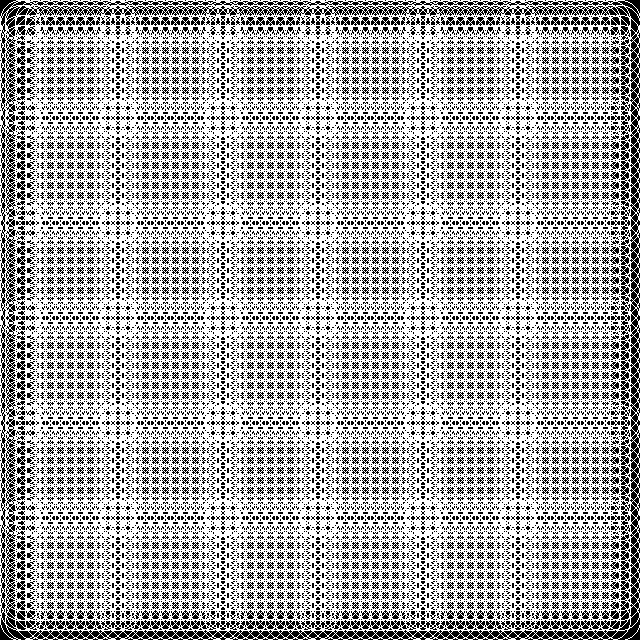

In [201]:
%%time
sz = config.sample_size
k = 5
retina_map_image = Image.new('RGBA', (sz * k, sz * k), color='black')
retina_map_draw = ImageDraw.Draw(retina_map_image)

for _, row in SENSOR_INSTANCES_INFO.iterrows():
    center_x = k * row.x_center
    center_y = k * row.y_center
    radius = k * row.radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)

retina_map_image

In [202]:
SENSOR_PATCH_COORDS = []

for row in SENSOR_INSTANCES_INFO.itertuples():
    x_offset = row.x_offset
    y_offset = row.y_offset
    size = row.size

    for i in range(size):
        y = (y_offset + i) * config.sample_size
        stride_coords = np.arange(y + x_offset, y + x_offset + size)
        SENSOR_PATCH_COORDS.append(stride_coords)

SENSOR_PATCH_COORDS = np.array(SENSOR_PATCH_COORDS)

In [203]:
def get_image_patches_for_sensor_instances(images_matrix):
    assert images_matrix.ndim == 2, images_matrix.ndim
    assert images_matrix.shape[1] == config.sample_size ** 2, images_matrix.shape[1]
    images_count = images_matrix.shape[0]
    # Result is 3d-tensor: 1 dim - image, 2 dim - patch no, 3 dim - patch itself (pixels)
    return np.take(images_matrix, SENSOR_PATCH_COORDS, axis=1).reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE)

## Images patching

In [204]:
a = np.arange(16).reshape(4,4)
a2 = a * (-2)
a2[3] += 1
a, a2

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([[  0,  -2,  -4,  -6],
        [ -8, -10, -12, -14],
        [-16, -18, -20, -22],
        [-23, -25, -27, -29]]))

In [205]:
# Get patches 2x2 from upper left and bottom right corners of both a and a2
x = np.take(np.vstack([a.ravel(), a2.ravel()]), [[0, 1], [4, 5], [10, 11], [14, 15]], axis=1).reshape(2, -1, 4)
x

array([[[  0,   1,   4,   5],
        [ 10,  11,  14,  15]],

       [[  0,  -2,  -8, -10],
        [-20, -22, -27, -29]]])

In [206]:
# Get mean of each patch
x.mean(axis=2)

array([[  2.5,  12.5],
       [ -5. , -24.5]])

In [207]:
# Recalculate patches against their mean and turn to shape: images(2), patches(2), pixels(4)
y = x.reshape(-1, 4).T - x.mean(axis=2).ravel()
y.T.reshape(2, -1, 4).transpose(0, 2, 1)

array([[[-2.5, -2.5],
        [-1.5, -1.5],
        [ 1.5,  1.5],
        [ 2.5,  2.5]],

       [[ 5. ,  4.5],
        [ 3. ,  2.5],
        [-3. , -2.5],
        [-5. , -4.5]]])

In [208]:
# Get min of each patch
x.min(axis=2)

array([[  0,  10],
       [-10, -29]])

In [209]:
# Replace patches with their min and turn to shape: images(2), patches(2), pixels(4)
y = x.reshape(-1, 4).T.copy()
assert y.base is None
y[:] = x.min(axis=2).ravel()
y.T.reshape(2, -1, 4).transpose(0, 2, 1)

array([[[  0,  10],
        [  0,  10],
        [  0,  10],
        [  0,  10]],

       [[-10, -29],
        [-10, -29],
        [-10, -29],
        [-10, -29]]])

In [210]:
image = np.empty((config.sample_size, config.sample_size), dtype='b')
image2 = np.empty((config.sample_size, config.sample_size), dtype='b')
images_matrix = np.vstack([image.ravel(), image2.ravel()])
images_count = images_matrix.shape[0]
images_patches = get_image_patches_for_sensor_instances(images_matrix)
images_patches.shape

(2, 4096, 64)

In [211]:
mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
mean_luminiscene_in_patches.shape

(2, 4096)

In [212]:
images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
images_patches = images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
images_patches.shape

(2, 64, 4096)

## Start

In [100]:
image_index = RNG.choice(len(x_train))
# image_index = 58980 # 4 with isthmus (ok)
# image_index = 38174 # 3 with isthmus (ok)
# image_index = 4900 # 1 unclosed right side (ok)
# image_index = 35616 # 4 unclosed top right side (ok)
# image_index = 8527 # 0 (ok)
# image_index = 12543 # 4 (ok)
# image_index = 59746 # 1 or 7 (ok)
# image_index = 13952 # 2 with loop (ok)
# image_index = 56318 # 0 (ok)
# image_index = 55199 # 2 with fat filled loop (ok)
# image_index = 46780 # 1 (ok)
# image_index = 4416 # 5 with separated hat (ok)
# image_index = 1199 # 2 big fat
# image_index = 26405 # 9 (~20% not traced)
# image_index = 12627 
# image_index = 1946 # 7 with isthmus. Part of 7 is not sequenced due to algo limitation - we only allow 2 branching of primary chains
# image_index = 52002 # 1 with isthmus (half not sequenced)
# image_index = 12603 # 2
# image_index = 57924 # 2
# image_index = 9322
# image_index = 1961 # 5 with isthmus

# 31478 (1), 9820 (0), 13269(9)
# image_index = 21694 # (8)
# image_index = 20188
# image_index = 14763

# image_index = 36694 # 2 with loop
# image_index = 28526 # 8 with broken top
# image_index = 34143 # 3
# image_index = 55174 # 7 with thick lines leading to complex landscape of iterior
image_index = 22657 

print(image_index)

with Image.frombytes('L', size=(28, 28), data=x_train[image_index]) as img:
    img = img.resize((config.sample_size, config.sample_size))
    image = np.array(img).ravel()

images_matrix = xp_array_to_gpu(image[np.newaxis,:])

22657


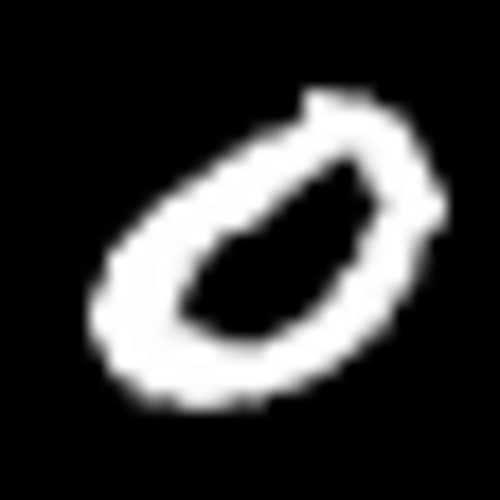

In [101]:
img.resize((500, 500))

## Sense

In [102]:
%%time
BRIGHT_ILLUMINATION_ABS_LEVEL = 255 * 0.5
# BRIGHT_ILLUMINATION_ABS_LEVEL = 255 * 0.25
# BRIGHT_ILLUMINATION_ABS_LEVEL = 999
BRIGHT_ILLUMINATION_DIRST_REL_DIFF = 0.75
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)
MINIMAL_PLUS_MINUS_DISTR_REL_DIFF = 0.9
MIN_COMBO_SCORE_VALUE = 1 + 1 + (MINIMAL_PLUS_MINUS_DISTR_REL_DIFF * 2) # 1 for abs illum MAC, 1 for diff abs illum mac, the last one is for +/- tallying

images_count = images_matrix.shape[0]
images_patches = get_image_patches_for_sensor_instances(images_matrix) # array of matrices: image no -> matrix with patches as row vectors

mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
mean_images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
mean_images_patches = mean_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
# mean_images_patches is an array of matrices: image no -> matrix with mean-centered patches as column vectors

min_luminiscene_in_patches = images_patches.min(axis=2) # matrix where each row = minimal of luminiscence in each patch of an image
min_images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T.copy()
assert min_images_patches.base is None # make sure we don't corrupt images_patches during next assignment
min_images_patches[:] = min_luminiscene_in_patches.ravel()
min_images_patches = min_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
# min_images_patches is an array of matrices: image no -> matrix with patches of minimal luminiscence as column vectors

images_patches = images_patches.transpose(0, 2, 1) # array of matrices: image no -> matrix with patches as column vectors
assert images_patches.shape == mean_images_patches.shape
assert images_patches.shape == min_images_patches.shape

abs_illum_level_pos = (SENSOR_STATES_POS @ images_patches).transpose(0, 2, 1)
abs_illum_level_neg = (SENSOR_STATES_NEG @ images_patches).transpose(0, 2, 1)
rel_illum_level_pos = (SENSOR_STATES_POS @ xp.where(mean_images_patches > 0, +1, 0)).transpose(0, 2, 1) # for +/- tallying
rel_illum_level_neg = (SENSOR_STATES_NEG @ xp.where(mean_images_patches < 0, -1, 0)).transpose(0, 2, 1)  # for +/- tallying
min_illum_level_pos = (SENSOR_STATES_POS @ min_images_patches).transpose(0, 2, 1)

assert abs_illum_level_pos.shape == (images_count, SENSORS_COUNT, SENSOR_STATES_COUNT), abs_illum_level_pos.shape
assert abs_illum_level_neg.shape == abs_illum_level_pos.shape
assert rel_illum_level_pos.shape == abs_illum_level_pos.shape
assert rel_illum_level_neg.shape == abs_illum_level_pos.shape
assert min_illum_level_pos.shape == abs_illum_level_pos.shape

sense_vectors = []
# For each patch in image we detect likelihood of activation of sensor in one of its (sensor's) state.
# If we have some state (say some angle and some sweep), what is condition that given patch corresponds to this state?
# Of course patch must be somewhat illuminated (regulated by SENSORS_POS) - this is to ensure that we don't get fooled by situation
# when e.g. negative part is not illuminated (dot prod is 0) while positive part is illuminated very, very week (say dot prod is 5). Looks
# like this is the reason why we don't hear very low frequencies or don't percieve low light - because ratio get oversaturaed very quickly.
# But the key point is that sum of pixels luminiscence can meet averaged criterion only when bright pixels are concentared in area covered by SENSORS_POS
# and dark pixels are concentrated in area covered by SENSORS_NEG. Otherwise there will disbalance.
# To detect this condition we can look at distribution of mean-centered patches: +pixels must reside in positive part, -pixels must reside in negative part.
# To restassure that +/- distribution of pixels actually corresponds to detectable diff in illumination we also need to compare
# absolute illumination on positive and negative part
for ailp_i, ailn_i, rilp_i, riln_i, milp_i in zip(abs_illum_level_pos, abs_illum_level_neg, rel_illum_level_pos, rel_illum_level_neg, min_illum_level_pos): # Per image cycle
    # Here and later on "patches count" 1-1 correspond to "sensor instances count" (for each sensor instance we prepare unique patch)
    # ailp_i and ailn_i both are matrices N(patches count) x M(count of sensor states)
    shape_save = ailp_i.shape

    # UBER - must be illuminated brightly and uniformly. I.e. 1) abs illum level (sum or products of SENSOR_STATE_POS X abs illum patches) must exceed bright criteria
    # 2) min illum level (sum of products of SENSOR_STATE_POS X min illum patches) must be close to abs illum level (this way we control minimal spread in illumination)
    bright_abs_illumination_scores = ailp_i > BRIGHT_ILLUMINATION_ABS_LEVEL * SENSOR_STATE_AREAS_POS
    uniform_illumination_scores = (milp_i / (ailp_i + 1e-6)) > BRIGHT_ILLUMINATION_DIRST_REL_DIFF

    # MAC {0, 1}
    # Illumination level on positive area must exceed lower threshold (sensor must be somewhat illuminated)
    # abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is minimally illuminated according to given sensor's state
    abs_illumination_scores = ailp_i > MINIMAL_ILLUMINATION_ABS_LEVEL * SENSOR_STATE_AREAS_POS

    # MAC {0, 1}
    # Illumination level on positive part must distinguishably exceed illumination level of negative part
    ailn_i += 1e-6 # to get rid of possible division by zero errors
    ailp_i = ailp_i / SENSOR_STATE_AREAS_POS
    ailn_i = ailn_i / SENSOR_STATE_AREAS_NEG
    diff_abs_illumination_scores = xp.abs(ailp_i.ravel() / ailn_i.ravel())
    diff_abs_illumination_scores = diff_abs_illumination_scores >= MINIMAL_ILLUMINATION_DIFF_RATIO
    # diff_abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is illuminated more on positive part than on negative
    diff_abs_illumination_scores = diff_abs_illumination_scores.reshape(shape_save)

    # Score {0, [MINIMAL_PLUS_MINUS_DISTR_REL_DIFF...1]}
    # Tally concentration of +/- pixels on positive/negative side and compare against theirs areas. 
    # For sensors with proper distribution ratio will be around 1 for each of the scores.
    # *concentration_scores = matrix of N(patches count), columns - [0...1] how well pixels in patch are distributed according to given sensor's state
    pluses_concentration_scores = rilp_i / SENSOR_STATE_AREAS_POS
    assert xp.all((pluses_concentration_scores >= 0) & (pluses_concentration_scores <= 1)) # comment for production (to speed up)
    mask = (pluses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
    pluses_concentration_scores = xp.where(mask, 0, pluses_concentration_scores)

    minuses_concentration_scores = riln_i / SENSOR_STATE_AREAS_NEG
    assert xp.all((minuses_concentration_scores >= 0) & (minuses_concentration_scores <= 1)) # comment for production (to speed up)
    mask = (minuses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
    minuses_concentration_scores = xp.where(mask, 0, minuses_concentration_scores)

    # sense_vector_uber = vector of N(patches count), each value - logical sum of UBER MACs for first sensor state 
    sense_vector_uber = bright_abs_illumination_scores[:,0] & uniform_illumination_scores[:,0]
    sense_vector_uber = xp.where(sense_vector_uber, 0, -1) # True -> 0 (UBER sensor state), False -> -1
    
    # sense_matrix = matrix of N(patches count), columns - sum of MACs and scores for given sensor state
    sense_matrix = (abs_illumination_scores.astype(float) + diff_abs_illumination_scores.astype(float) + pluses_concentration_scores + minuses_concentration_scores)
    # take all columns except the first one. First column is an UBER sensor state intended for detection of completely illuminated patch. 
    # UBER sensor state is evaluated if other sensor states didn't respond.
    sense_submatrix = sense_matrix[:,1:] 
    sense_vector = xp.where(xp.any(sense_submatrix > MIN_COMBO_SCORE_VALUE, axis=1), 1 + xp.argmax(sense_submatrix, axis=1), -1)
    sense_vector = xp.where(sense_vector == -1, sense_vector_uber, sense_vector)
    sense_vectors.append(sense_vector)

sense_vectors = xp.vstack(sense_vectors)

CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 136 ms


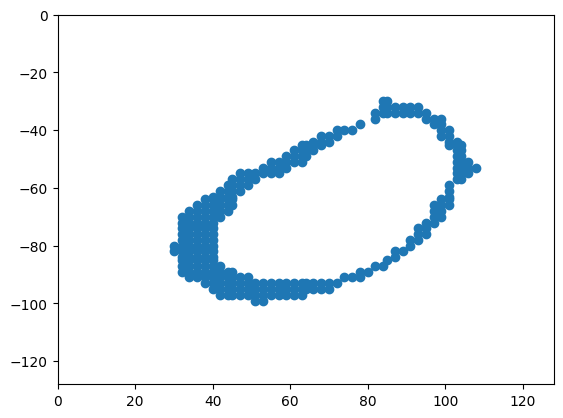

In [103]:
ii = np.argwhere(~sense_vector_uber).ravel()
xy = np.array(list(map(lambda i: tuple(SENSOR_INSTANCES_INFO.loc[i][['x_center', 'y_center']]), ii)))
plt.xlim(0, 128)
plt.ylim(-128, 0)
plt.scatter(xy[:,0], -xy[:,1])
plt.show()

In [104]:
SequencingContext = namedtuple('SequencingContext', 
                               ['altitude_map_hires', 
                                'altitude_lores_to_hires_translate_factor', 
                                'si_list', 
                                'outer_grooves', 
                                'outer_si_ind_dict',
                                'inner_grooves',
                                'inner_si_ind_dict',
                                'outer_raw_sequences',
                                'inner_raw_sequences'],
                              defaults = [None] * 9)
seq_context = SequencingContext()

In [105]:
assert sense_vector.shape[0] == len(SENSOR_INSTANCES_INFO)
sensor_instance_inds = np.argwhere(sense_vector != -1).ravel()
sensor_state_inds = np.take(sense_vector, sensor_instance_inds)
assert sensor_instance_inds.shape[0] == sensor_state_inds.shape[0]
df_sensor_instances_uberraw = pd.DataFrame({'sensor_instance_ind': sensor_instance_inds, 'sensor_state_ind': sensor_state_inds})
df_sensor_instances_uberraw = df_sensor_instances_uberraw.merge(SENSOR_STATES_INFO, how='left', left_on='sensor_state_ind', right_index=True)
df_sensor_instances_uberraw = df_sensor_instances_uberraw.merge(SENSOR_INSTANCES_INFO, how='left', left_on='sensor_instance_ind', right_index=True)
df_sensor_instances_uberraw.rename({'x_center': 'x', 'y_center': 'y'}, axis=1, inplace=True, errors='raise')
df_sensor_instances_uberraw[['x2', 'y2']] = df_sensor_instances_uberraw[['x', 'y']]
df_sensor_instances_raw = df_sensor_instances_uberraw.loc[df_sensor_instances_uberraw.sensor_state_ind != 0].copy()
df_sensor_instances_raw.drop(['sensor_instance_ind', 'sensor_state_ind', 'bounds_rect', 'sweep_vec', 'sweep1_vec', 'sweep2_vec', 'radius'], axis=1, inplace=True)
si_list_uberraw = list(df_sensor_instances_uberraw.itertuples())
si_list_raw = list(df_sensor_instances_raw.itertuples())
len(si_list_uberraw), len(si_list_raw)

(956, 686)

In [106]:
df_sensor_instances_uberraw.head(1)

,sensor_instance_ind,sensor_state_ind,normal,sweep,normal_vec,sweep_vec,sweep1_vec,sweep2_vec,x_offset,y_offset,size,bounds_rect,x,y,radius,x2,y2
0,616,145,250,270,-0.342020-0.939693j,-0.0-1.0j,0.906308+0.422618j,-0.422618+0.906308j,76,17,8,"[76, 17, 83, 24]",80,21,4,80,21


In [107]:
df_sensor_instances_raw.head(1)

,normal,sweep,normal_vec,x_offset,y_offset,size,x,y,x2,y2
0,250,270,-0.342020-0.939693j,76,17,8,80,21,80,21


## Altitude map

In [108]:
ALTITUDE_INNER = 3

In [109]:
%%time
altitude_map_lores = np.zeros((config.sample_size, config.sample_size))

for si in si_list_uberraw:
    sensor_state = SENSOR_STATES[si.sensor_state_ind]
    size = si.size
    altitude_map_lores[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] += sensor_state.reshape(size, size)

min_altitude = np.min(altitude_map_lores)
altitude_map_si_abscence_mask = np.full_like(altitude_map_lores, min_altitude, dtype='i')

for si in si_list_uberraw:
    altitude_map_si_abscence_mask[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] = 0

altitude_map_lores += altitude_map_si_abscence_mask
altitude_map_lores = altitude_map_lores.astype('i')

CPU times: user 2.24 ms, sys: 0 ns, total: 2.24 ms
Wall time: 2.21 ms


In [110]:
%%time
altitude_extend_by = 5 # number of new intermediate cells for each side of 2x2 rect, e.g. 3x3 becomes 13x13 if altitude_extend_by is 5
altitude_lores_to_hires_translate_factor = (altitude_extend_by + 1)
altitude_map_hires_size = (config.sample_size - 1) * altitude_lores_to_hires_translate_factor + 1
altitude_map_hires = np.zeros((altitude_map_hires_size, altitude_map_hires_size), dtype='f')
patch_hires_shape = (2 + altitude_extend_by, 2 + altitude_extend_by)
ii, jj = np.mgrid[0:patch_hires_shape[0], 0:patch_hires_shape[1]]
patch_hires_indices = np.array(list(zip(ii.ravel(), jj.ravel())))

for i in range(altitude_map_lores.shape[0] - 1):
    for j in range(altitude_map_lores.shape[1] - 1):
        patch = altitude_map_lores[i:i+2, j:j+2].astype(float)

        if patch[0,0] == patch[0,1] and patch[0,1] == patch[1,0] and patch[1,0] == patch[1,1]:
            patch_hires = patch[0,0]
        else:
            interp = RegularGridInterpolator(([0, patch_hires_shape[0] - 1], [0, patch_hires_shape[1] - 1]), patch)
            patch_hires = interp(patch_hires_indices).reshape(patch_hires_shape)
            
        i_hires = i * altitude_lores_to_hires_translate_factor
        j_hires = j * altitude_lores_to_hires_translate_factor
        altitude_map_hires[i_hires:i_hires+patch_hires_shape[0], j_hires:j_hires+patch_hires_shape[1]] = patch_hires

altitude_map_hires = altitude_map_hires.astype('i')
altitude_map_hires[altitude_map_hires > ALTITUDE_INNER - 1] = ALTITUDE_INNER

seq_context = seq_context._replace(altitude_map_hires=altitude_map_hires, altitude_lores_to_hires_translate_factor=altitude_lores_to_hires_translate_factor)
del altitude_map_hires
del altitude_lores_to_hires_translate_factor

CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 231 ms


## Cliffing

In [111]:
si_list = []
xy_unique = set()

for si in si_list_raw:
    x = int(si.x * seq_context.altitude_lores_to_hires_translate_factor)
    y = int(si.y * seq_context.altitude_lores_to_hires_translate_factor)
    altitude = seq_context.altitude_map_hires[y, x]
    is_top_altitude_reached = False
    travel_point = complex(x, y)

    for _ in range(100): # fail fast on too many iterations (shouldn't happen often)
        x = int(travel_point.real)
        y = int(travel_point.imag)

        if x >= 0 and x < seq_context.altitude_map_hires.shape[1] and y >= 0 and y < seq_context.altitude_map_hires.shape[0]:
            if seq_context.altitude_map_hires[y, x] >= ALTITUDE_INNER:
                is_top_altitude_reached = True
                break
        else:
            # we've hit image boundaries, ignore this si (alternative implementation may be possible though)
            break
            
        travel_point -= si.normal_vec # crawl in direction opposite to normal

    if not is_top_altitude_reached:
        continue

    is_cliff_reached = False
        
    for _ in range(100):
        x = int(travel_point.real)
        y = int(travel_point.imag)

        if x >= 0 and x < seq_context.altitude_map_hires.shape[1] and y >= 0 and y < seq_context.altitude_map_hires.shape[0]:
            if seq_context.altitude_map_hires[y, x] < ALTITUDE_INNER:
                # This si falled out of cliff
                break
        
        for rel_xy in itertools.product(range(-1, 1 + 1), repeat=2):
            test_x = x + rel_xy[0]
            test_y = y + rel_xy[1]
    
            if test_x < 0 or test_y < 0 or test_x >= seq_context.altitude_map_hires.shape[1] or test_y >= seq_context.altitude_map_hires.shape[0]:
                continue
            elif seq_context.altitude_map_hires[test_y, test_x] >= ALTITUDE_INNER:
                continue
            
            is_cliff_reached = True
            break
        else:
            travel_point += si.normal_vec

        if is_cliff_reached:
            break
                    
    if is_cliff_reached:
        if not (x, y) in xy_unique:
            # Make sure NO xy lays on the edge of altitude map boundaries (otherwise we will face with constant checks and code will be complicated/slowdown)
            assert x > 0 and x < seq_context.altitude_map_hires.shape[1] - 1
            assert y > 0 and y < seq_context.altitude_map_hires.shape[0] - 1
            x_lores = round(x / seq_context.altitude_lores_to_hires_translate_factor)
            y_lores = round(y / seq_context.altitude_lores_to_hires_translate_factor)
            si_list.append(si._replace(x2=x, y2=y, x=x_lores, y=y_lores))
            xy_unique.add((x, y))

seq_context = seq_context._replace(si_list=si_list)
del si_list
len(seq_context.si_list)

623

In [112]:
seq_context.si_list[:5]

[Pandas(Index=0, normal=250, sweep=270, normal_vec=(-0.34202014332566855-0.9396926207859084j), x_offset=76, y_offset=17, size=8, x=80, y=22, x2=483, y2=135),
 Pandas(Index=1, normal=270, sweep=270, normal_vec=(-1.8369701987210297e-16-1j), x_offset=89, y_offset=17, size=8, x=93, y=25, x2=558, y2=150),
 Pandas(Index=2, normal=210, sweep=270, normal_vec=(-0.8660254037844386-0.5000000000000001j), x_offset=72, y_offset=19, size=8, x=78, y=24, x2=466, y2=144),
 Pandas(Index=3, normal=210, sweep=270, normal_vec=(-0.8660254037844386-0.5000000000000001j), x_offset=74, y_offset=19, size=8, x=78, y=23, x2=468, y2=138),
 Pandas(Index=4, normal=240, sweep=230, normal_vec=(-0.5000000000000004-0.8660254037844384j), x_offset=76, y_offset=19, size=8, x=80, y=22, x2=478, y2=135)]

## Outer grooves

In [113]:
COS_SIM_120 = -1 / 2
COS_SIM_45 = np.sqrt(2) / 2

In [114]:
NEAREST_NEIGHB_REL_XY_LIST = list(itertools.product(range(-1, 1 + 1), repeat=2))
NEAREST_NEIGHB_REL_XY_LIST.remove((0, 0))
NEAREST_NEIGHB_REL_XY_LIST = np.array(NEAREST_NEIGHB_REL_XY_LIST)
NEAREST_NEIGHB_REL_XY_LIST

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

In [115]:
%%time
wave_fronts = deque()
xy_touched = set()

for si_ind, si in enumerate(seq_context.si_list):
    x, y = (si.x2, si.y2)
    assert not (x, y) in xy_touched
    xy_touched.add((x, y))
    wave_fronts.append((x, y, si_ind))
    
outer_grooves_map = np.full_like(seq_context.altitude_map_hires, -1, dtype='i')

while wave_fronts:
    x, y, si_ind = wave_fronts.popleft()
    assert outer_grooves_map[y, x] == -1, outer_grooves_map[y, x]

    # point at x,y must be on cliff - i.e. one of its neighbours must be out of plateau (altitude=3)
    for rel_xy in NEAREST_NEIGHB_REL_XY_LIST:
        test_x = x + rel_xy[0]
        test_y = y + rel_xy[1]

        # if test_x < 0 or test_y < 0 or test_x >= seq_context.altitude_map_hires.shape[1] or test_y >= seq_context.altitude_map_hires.shape[0]:
        #     continue
        # elif 
        if seq_context.altitude_map_hires[test_y, test_x] < ALTITUDE_INNER:
            # cliff condition met
            break
    else:
        continue
    
    outer_grooves_map[y, x] = si_ind

    for rel_xy in NEAREST_NEIGHB_REL_XY_LIST:
        test_x = x + rel_xy[0]
        test_y = y + rel_xy[1]

        # if test_x < 0 or test_y < 0 or test_x >= seq_context.altitude_map_hires.shape[1] or test_y >= seq_context.altitude_map_hires.shape[0]:
        #     continue
        # elif 
        if seq_context.altitude_map_hires[test_y, test_x] < ALTITUDE_INNER:
            continue
        elif outer_grooves_map[test_y, test_x] != -1:
            continue
        elif (test_x, test_y) in xy_touched:
            continue

        wave_fronts.append((test_x, test_y, si_ind))
        xy_touched.add((test_x, test_y))

outer_grooves = []

for ij in np.argwhere(outer_grooves_map != -1):
    x, y = int(ij[1]), int(ij[0])
    si_ind = outer_grooves_map[y, x]
    outer_grooves.append((x, y, si_ind))

outer_grooves = np.array(outer_grooves)
outer_si_ind_dict = dict(map(lambda si_ind_si: (si_ind_si[0], si_ind_si[1]), enumerate(seq_context.si_list)))

seq_context = seq_context._replace(outer_grooves=outer_grooves, outer_si_ind_dict=outer_si_ind_dict)
del outer_grooves
del outer_si_ind_dict

CPU times: user 59.9 ms, sys: 997 μs, total: 60.9 ms
Wall time: 60.1 ms


In [116]:
temp = defaultdict(set)

for x, y, si_ind in seq_context.outer_grooves:
    assert si_ind in seq_context.outer_si_ind_dict
    temp[si_ind].add((x, y))

for si_ind, si in seq_context.outer_si_ind_dict.items():
    assert si_ind in temp
    xy_set = temp[si_ind]
    assert (si.x2, si.y2) in xy_set

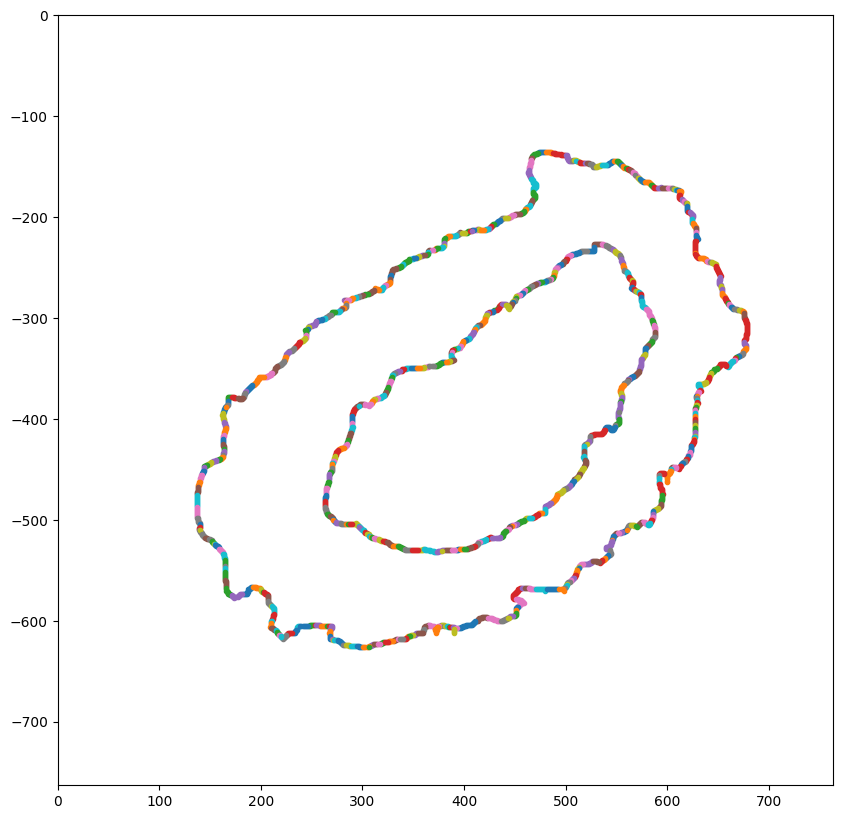

In [117]:
temp = defaultdict(list)

plt.figure(figsize=(10, 10))

for x, y, si_ind in seq_context.outer_grooves:
    temp[si_ind].append((x, y))

for si_ind, xxyy in temp.items():
    xxyy = np.array(xxyy)
    plt.scatter(xxyy[:,0], -xxyy[:,1], marker='.', label=str(si_ind))

plt.xlim(0, seq_context.altitude_map_hires.shape[1])
plt.ylim(-seq_context.altitude_map_hires.shape[0], 0)
# plt.legend()
plt.show()

## Inner grooves

In [118]:
%%time
wave_fronts = deque()
xy_touched = set()

for x, y, si_ind in seq_context.outer_grooves:
    xy_touched.add((x, y))
    wave_fronts.append((x, y, si_ind))

inner_grooves_map = np.full_like(seq_context.altitude_map_hires, -1, dtype='i')
inner_grooves = []
inner_groove_bits = []
rel_xy_list = NEAREST_NEIGHB_REL_XY_LIST.copy()

while wave_fronts:
    x, y, si_ind = wave_fronts.popleft()
    assert inner_grooves_map[y, x] == -1, inner_grooves_map[y, x]
    inner_grooves_map[y, x] = si_ind
    is_amberified = True

    RNG.shuffle(rel_xy_list)
    
    for rel_xy in rel_xy_list:
        test_x = x + rel_xy[0]
        test_y = y + rel_xy[1]

        # if test_x < 0 or test_y < 0 or test_x >= seq_context.altitude_map_hires.shape[1] or test_y >= seq_context.altitude_map_hires.shape[0]:
        #     continue
        # elif 
        if seq_context.altitude_map_hires[test_y, test_x] < ALTITUDE_INNER:
            continue
        elif inner_grooves_map[test_y, test_x] != -1:
            continue
        elif (test_x, test_y) in xy_touched:
            continue

        wave_fronts.append((test_x, test_y, si_ind))
        xy_touched.add((test_x, test_y))
        is_amberified = False

    if is_amberified:
        inner_groove_bits.append((x, y))
        si_ind_normal_vec = seq_context.si_list[si_ind].normal_vec
        
        for rel_xy in NEAREST_NEIGHB_REL_XY_LIST:
            test_x = x + rel_xy[0]
            test_y = y + rel_xy[1]
    
            # if test_x < 0 or test_y < 0 or test_x >= inner_grooves_map.shape[1] or test_y >= inner_grooves_map.shape[0]:
            #     continue
            # elif 
            if inner_grooves_map[test_y, test_x] == -1:
                continue
            
            other_si_ind = inner_grooves_map[test_y, test_x]

            if si_ind == other_si_ind:
                continue
                
            other_si_ind_normal_vec = seq_context.si_list[other_si_ind].normal_vec
            dot_prod = si_ind_normal_vec.real * other_si_ind_normal_vec.real + si_ind_normal_vec.imag * other_si_ind_normal_vec.imag

            if dot_prod < 0: 
                inner_grooves.append((x, y, si_ind))
                break

inner_grooves = np.array(inner_grooves)
inner_si_ind_dict = {}

for i in range(inner_grooves.shape[0]):
    x, y, si_ind = inner_grooves[i]
    si = seq_context.si_list[si_ind]
    x_lores = round(x / seq_context.altitude_lores_to_hires_translate_factor)
    y_lores = round(y / seq_context.altitude_lores_to_hires_translate_factor)
    new_si_ind_value = len(inner_si_ind_dict)
    inner_si_ind_dict[new_si_ind_value] = si._replace(x2=int(x), y2=int(y), x=x_lores, y=y_lores)
    inner_grooves[i, 2] = new_si_ind_value

seq_context = seq_context._replace(inner_grooves=inner_grooves, inner_si_ind_dict=inner_si_ind_dict)
del inner_grooves
del inner_si_ind_dict

CPU times: user 1.2 s, sys: 1.97 ms, total: 1.2 s
Wall time: 1.2 s


In [119]:
# temp = defaultdict(set)

# for x, y, si_ind in inner_grooves:
#     assert si_ind in inner_si_ind_dict
#     temp[si_ind].add((x, y))

# for si_ind, si in inner_si_ind_dict.items():
#     assert si_ind in temp
#     xy_set = temp[si_ind]
#     assert (si.x2, si.y2) in xy_set

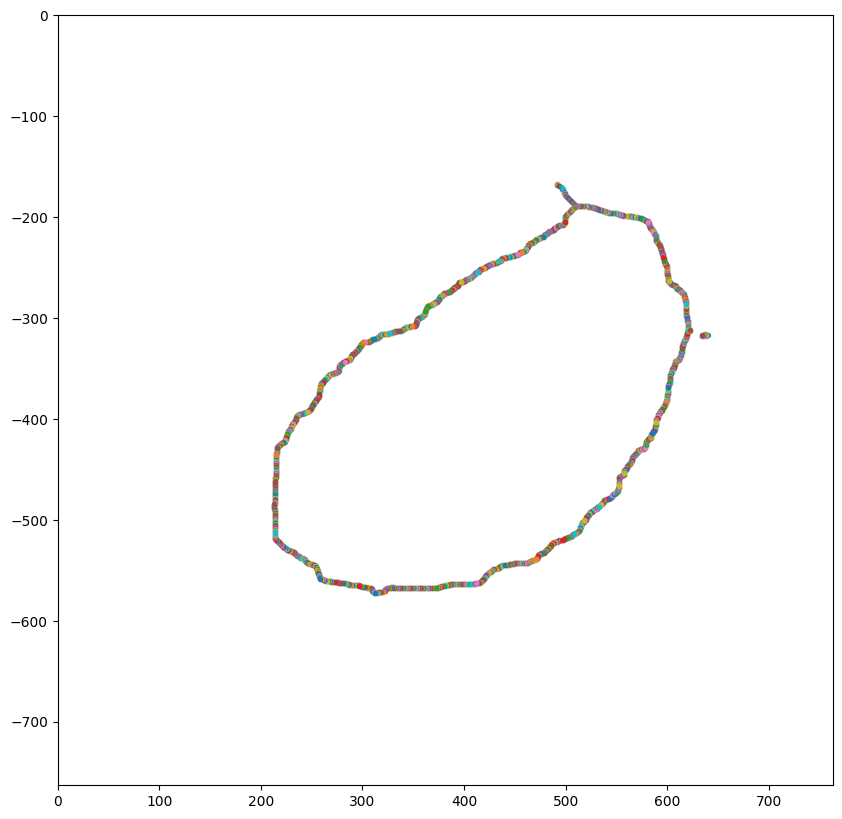

In [120]:
temp = defaultdict(list)

plt.figure(figsize=(10, 10))

for x, y, si_ind in seq_context.inner_grooves:
    temp[si_ind].append((x, y))

for si_ind, xxyy in temp.items():
    xxyy = np.array(xxyy)
    plt.scatter(xxyy[:,0], -xxyy[:,1], marker='.', label=str(si_ind))

plt.xlim(0, seq_context.altitude_map_hires.shape[1])
plt.ylim(-seq_context.altitude_map_hires.shape[0], 0)
# plt.legend()
plt.show()

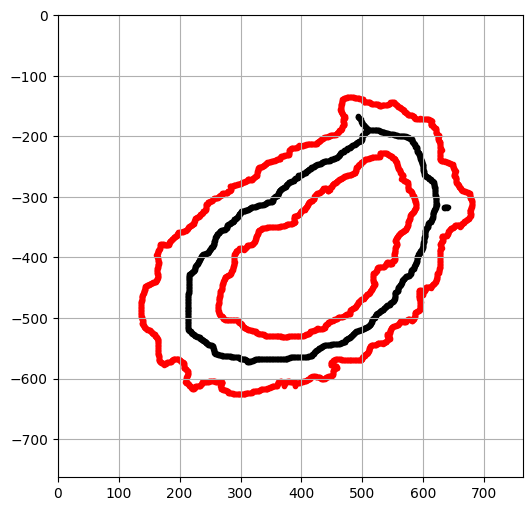

In [121]:
plt.figure(figsize=(6, 6))

plt.scatter(seq_context.inner_grooves[:,0], -seq_context.inner_grooves[:,1], color='black', marker='.')
plt.scatter(seq_context.outer_grooves[:,0], -seq_context.outer_grooves[:,1], color='red', marker='.')

plt.xlim(0, seq_context.altitude_map_hires.shape[1])
plt.ylim(-seq_context.altitude_map_hires.shape[0], 0)
plt.grid()
plt.show()

## Raw sequences

In [122]:
list(filter(lambda row: row[2] > 2000, seq_context.inner_grooves))

[]

In [123]:
GROOVE_ENDPOINT_TEMPLATE = np.array([[1, 1, 0], [1, 0, 0], [1, 1, 1]])
GROOVE_ENDPOINT_TEMPLATES = []

for t in [GROOVE_ENDPOINT_TEMPLATE, np.fliplr(GROOVE_ENDPOINT_TEMPLATE)]:
    GROOVE_ENDPOINT_TEMPLATES.append(t)
    GROOVE_ENDPOINT_TEMPLATES.append(np.rot90(t))
    GROOVE_ENDPOINT_TEMPLATES.append(np.rot90(np.rot90(t)))
    GROOVE_ENDPOINT_TEMPLATES.append(np.rot90(np.rot90(np.rot90(t))))

GROOVE_ENDPOINT_TEMPLATES = np.array(GROOVE_ENDPOINT_TEMPLATES)

def get_outer_starting_si_ind(grooves, unprocessed_si_inds, seq_context):
    # outer si_inds corresponds to a circular contour, 
    # so we can start anywhere (i.e. from any si)
    return next(iter(unprocessed_si_inds))

def get_inner_starting_si_ind(grooves, unprocessed_si_inds, seq_context):
    grooves_map = np.full_like(seq_context.altitude_map_hires, -1, dtype='i')
    grooves_unprocessed = list(filter(lambda row: row[2] in unprocessed_si_inds, grooves))

    for x, y, si_ind in grooves_unprocessed:
        grooves_map[y, x] = si_ind
        
    for x, y, si_ind in grooves_unprocessed:
        assert x > 0
        assert y > 0
        assert x < grooves_map.shape[1] - 1
        assert y < grooves_map.shape[0] - 1
        patch = grooves_map[y-1:y+2, x-1:x+2]
        s = (GROOVE_ENDPOINT_TEMPLATES * patch).reshape(GROOVE_ENDPOINT_TEMPLATES.shape[0], -1).sum(axis=-1)
        
        if np.any(s == -6):
            return si_ind

    # If we get here that means that there is no endpoints =( Looks like only loops are left, take any si_ind
    return next(iter(unprocessed_si_inds))

In [124]:
LOG.is_enabled = False

In [125]:
%%time
seq_context = seq_context._replace(outer_raw_sequences={}, inner_raw_sequences={})
# iterables = zip([seq_context.outer_raw_sequences], [seq_context.outer_grooves], [seq_context.outer_si_ind_dict], [get_outer_starting_si_ind])
# iterables = zip([seq_context.inner_raw_sequences], [seq_context.inner_grooves], [seq_context.inner_si_ind_dict], [get_inner_starting_si_ind])
iterables = zip([seq_context.outer_raw_sequences, seq_context.inner_raw_sequences], 
                [seq_context.outer_grooves, seq_context.inner_grooves], 
                [seq_context.outer_si_ind_dict, seq_context.inner_si_ind_dict], 
                [get_outer_starting_si_ind, get_inner_starting_si_ind])

for raw_sequences, grooves, si_ind_dict, get_starting_si_ind in iterables:
    grooves_map = np.full_like(seq_context.altitude_map_hires, -1, dtype='i')

    for x, y, si_ind in grooves:
        grooves_map[y, x] = si_ind
    
    xy_on_grooves_to_si_ind = dict(map(lambda item: ((item[1].x2, item[1].y2), item[0]), si_ind_dict.items()))  # xy -> si_ind. Deduplication by xy happens here
    unprocessed_si_inds = set(grooves[:,2])
    # unprocessed_si_inds = set([5])
    
    while unprocessed_si_inds:
        start_sensor_inst_index = get_starting_si_ind(grooves, unprocessed_si_inds, seq_context)
        si = si_ind_dict[start_sensor_inst_index]
        si_xy = (si.x2, si.y2)
        si_ij = int(si_xy[1]), int(si_xy[0])
        
        wave_front_que = deque([si_ij])
        wave_front_map = np.full_like(seq_context.altitude_map_hires, -1, dtype='i')
        wave_front_map[wave_front_que[0]] = start_sensor_inst_index
        wave_front_touched = set([wave_front_que[0]])
        
        # sensor_inst_chains = {} # key - last element in chain of sensor instances, value - chain itself
        sensor_inst_chains = {start_sensor_inst_index: [start_sensor_inst_index]} # key - last element in chain of sensor instances, value - chain itself
        
        LOG(f'Starting walk from {start_sensor_inst_index} (of {len(unprocessed_si_inds)})')
        
        while wave_front_que:
            # Visit point on top of the wave_front
            wave_front_point = wave_front_que.popleft()
            wave_front_sensor_inst_ind = int(wave_front_map[wave_front_point])
            wave_front_sensor_inst_ind1 = wave_front_sensor_inst_ind
            wave_front_map[wave_front_point] = -1
            assert wave_front_sensor_inst_ind > -1
            LOG(f'Visiting {wave_front_point} (si={wave_front_sensor_inst_ind}) (of {len(wave_front_que)})')
        
            si_ind = xy_on_grooves_to_si_ind.get((wave_front_point[1], wave_front_point[0]), -1)
        
            if si_ind != -1 and si_ind != wave_front_sensor_inst_ind:
                # New sensor instance discovered! Link with the previous one, ...
                sensor_inst_chain = sensor_inst_chains.pop(wave_front_sensor_inst_ind, [wave_front_sensor_inst_ind])
                sensor_inst_chain.append(si_ind)
                assert not si_ind in sensor_inst_chains, f'{si_ind} in sensor_inst_chains'
                sensor_inst_chains[si_ind] = sensor_inst_chain
                
                LOG(f'New si encountered: {si_ind}, linked after {wave_front_sensor_inst_ind}')
                wave_front_sensor_inst_ind = si_ind
                # ... and adjust adjacent wave front points to account for new sensor instance
                # (adjacency criteria enables coexisting of separate (disjoint) wave fronts on a map)
                adjust_stack = [wave_front_point]
                adjust_touched = set([wave_front_point])
        
                while adjust_stack:
                    adjust_point = adjust_stack.pop()
        
                    for rel_ij in [[0, -1], [-1, 0], [0, 1], [1, 0], [-1, -1], [-1, 1], [1, 1], [1, -1]]:
                        ij = int(adjust_point[0] + rel_ij[0]), int(adjust_point[1] + rel_ij[1])
                
                        # if ij[0] < 0 or ij[1] < 0 or ij[0] >= wave_front_map.shape[0] or ij[1] >= wave_front_map.shape[1]:
                        #     # if wave_front_sensor_inst_ind1 == 573:
                        #     #     LOG(f'kms@ 1) {ij}')
                                
                        #     continue
                        # elif 
                        if wave_front_map[ij] == -1:
                            # if wave_front_sensor_inst_ind1 == 573:
                            #     LOG(f'kms@ 2) {ij} {wave_front_map[ij]}')
                                
                            continue
                        elif ij in adjust_touched:
                            # if wave_front_sensor_inst_ind1 == 573:
                            #     LOG(f'kms@ 3) {ij}')
                                
                            continue
        
                        LOG(f'Adjusting {ij} (si={wave_front_map[ij]}) to si={si_ind}')
                        wave_front_map[ij] = si_ind
                        adjust_stack.append(ij)
                        adjust_touched.add(ij)
        
            # Plan further spread of the wave front
            for rel_ij in [[0, -1], [-1, 0], [0, 1], [1, 0], [-1, -1], [-1, 1], [1, 1], [1, -1]]:
                ij = int(wave_front_point[0] + rel_ij[0]), int(wave_front_point[1] + rel_ij[1])
                LOG(f'... spread, checking coord {rel_ij} {ij}')
        
                # if ij[0] < 0 or ij[1] < 0 or ij[0] >= grooves_map.shape[0] or ij[1] >= grooves_map.shape[1]:
                #     LOG(f'... spread, {ij} out of boundaries')
                #     continue
                # elif 
                if grooves_map[ij] == -1:  # coord_ij falls out of groove
                    LOG(f'... spread, {ij} is out of groove')
                    continue
                elif ij in wave_front_touched:
                    LOG(f'... spread, {ij} already touched ({len(wave_front_touched)})')
                    continue
        
                wave_front_touched.add(ij)
                wave_front_que.append(ij)
                wave_front_map[ij] = wave_front_sensor_inst_ind
                LOG(f'... new wave front point {wave_front_que[-1]} (si={wave_front_sensor_inst_ind})')

        if sensor_inst_chains:
            raw_sequences[start_sensor_inst_index] = sensor_inst_chains
            
        # Collect all sensor instances encountered during this run and mark them as processed
        processed_si_inds = set(itertools.chain.from_iterable(sensor_inst_chains.values()))
        unprocessed_si_inds -= processed_si_inds

CPU times: user 82.6 ms, sys: 961 μs, total: 83.6 ms
Wall time: 82.6 ms


In [126]:
seq_context.outer_raw_sequences.keys(), seq_context.inner_raw_sequences.keys()

(dict_keys([np.int64(0), np.int64(89)]),
 dict_keys([np.int64(1), np.int64(309), np.int64(355)]))

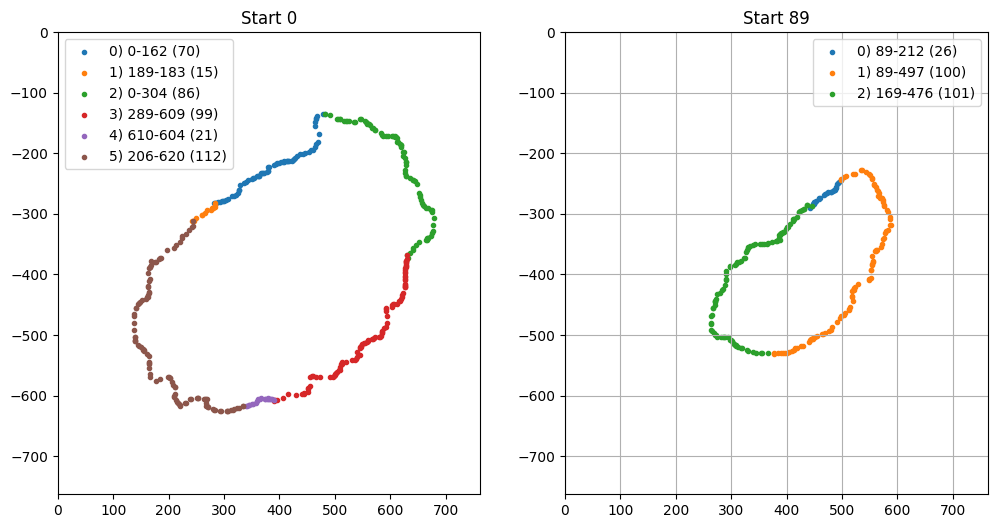

In [127]:
subplots_count = len(seq_context.outer_raw_sequences.keys())
plt.figure(figsize=(6 * subplots_count, 6))

for i, k in enumerate(seq_context.outer_raw_sequences.keys()):
    plt.subplot(1, subplots_count, i + 1)
    plt.xlim(0, seq_context.altitude_map_hires.shape[0])
    plt.ylim(-seq_context.altitude_map_hires.shape[0], 0)
    plt.title(f'Start {k}')
    
    for i, chain in enumerate(seq_context.outer_raw_sequences[k].values()):
        pts = np.array(list(map(lambda n: (seq_context.outer_si_ind_dict[n].x2, seq_context.outer_si_ind_dict[n].y2), chain)))
        plt.scatter(pts[:,0], -pts[:,1], marker='.', label=f'{i}) {chain[0]}-{chain[-1]} ({len(chain)})')
        
    plt.legend()

plt.grid()
plt.show()

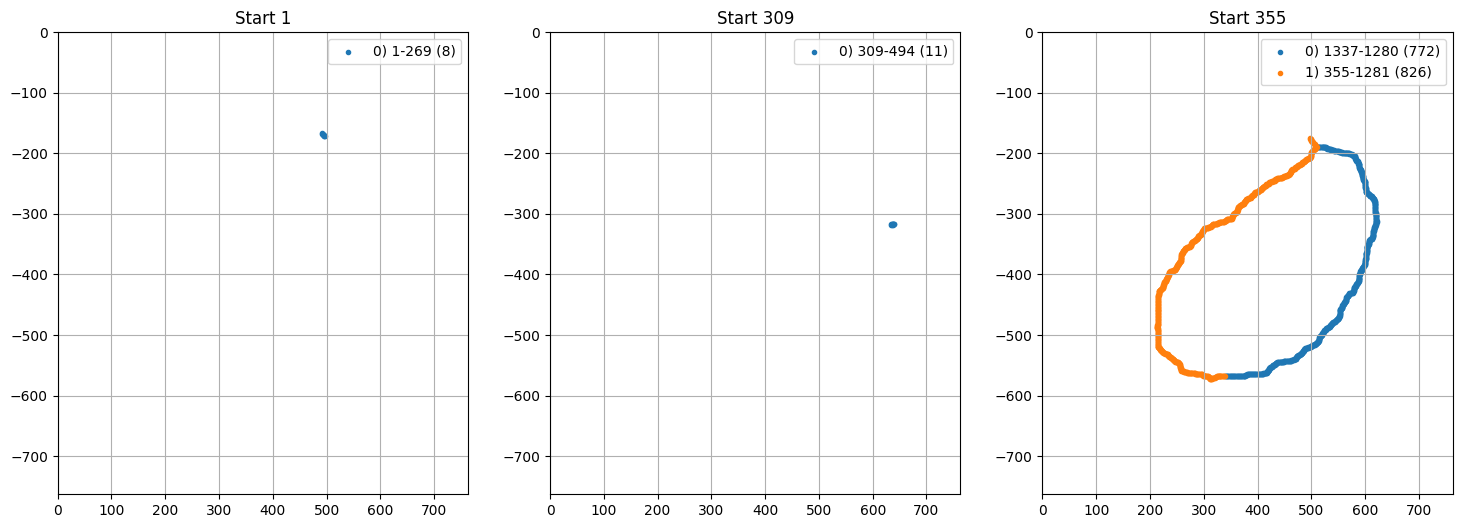

In [128]:
subplots_count = len(seq_context.inner_raw_sequences.keys())
plt.figure(figsize=(6 * subplots_count, 6))

for i, k in enumerate(seq_context.inner_raw_sequences.keys()):
    plt.subplot(1, subplots_count, i + 1)
    plt.xlim(0, seq_context.altitude_map_hires.shape[0])
    plt.ylim(-seq_context.altitude_map_hires.shape[0], 0)
    plt.title(f'Start {k}')
    
    for i, chain in enumerate(seq_context.inner_raw_sequences[k].values()):
        pts = np.array(list(map(lambda n: (seq_context.inner_si_ind_dict[n].x2, seq_context.inner_si_ind_dict[n].y2), chain)))
        plt.scatter(pts[:,0], -pts[:,1], marker='.', label=f'{i}) {chain[0]}-{chain[-1]} ({len(chain)})')

    plt.grid()
    plt.legend()
    
plt.show()

## Weave outer

In [129]:
%%time
outer_sequences = []
    
for sensor_inst_chains in seq_context.outer_raw_sequences.values():
    # Our goal is to find two longest subsequence which start from the same si and clue them together. 
    # Usually this would be two subsequences starting from start_sensor_inst_index.
    # This way we would get longest serial sequence of traverse
    subsequences = []
    
    for chain_index, chain in enumerate(sensor_inst_chains.values()):
        # get all chains OTHER THAN current chain under chain_index
        chains_wo_chain_index = map(lambda v: v[1], filter(lambda v: v[0] != chain_index, enumerate(sensor_inst_chains.values())))
        chains_dict = defaultdict(list)
        for v in chains_wo_chain_index: chains_dict[v[0]].append(v)
        
        subsequences.append([])
        branch_stack = [(chain, 0, len(subsequences) - 1)]
        LOG(f'Starting new subsequence #{len(subsequences) - 1}, {chain[0]}')
    
        while branch_stack:
            chain, chain_elem_index, subseq_index = branch_stack.pop()
            subseq = subsequences[subseq_index]
            LOG(f'Weaving subsequence #{subseq_index}, {chain[chain_elem_index]}')
            
            for i in range(chain_elem_index, len(chain)):
                v = chain[i]
                subseq.append(v)
                LOG(f'... adding {chain[i]}, subseq len={len(subseq)}, subseq[:3]={subseq[:3]}, subseq[-3:]={subseq[-3:]}')
    
                if v in chains_dict:
                    LOG(f'... branch point detected')
                    # New branch point detected
                    branch_stack.append((chain, i + 1, subseq_index)) # continue sequence by following current chain

                    # Start new subsequences from new chain
                    for branch_chain in chains_dict[v]:
                        new_subseq = subseq.copy()
                        subsequences.append(new_subseq)
                        branch_stack.append((branch_chain, 1, len(subsequences) - 1)) # create new sequence and follow new chain
                        LOG(f'... branching new subsequence #{len(subsequences) - 1}, {branch_chain[1]}')
                        
                    break

    longest_sequence = []

    if not subsequences:
        continue
    elif len(subsequences) == 1:
        longest_subsequence = subsequences[0]
    else:
        for ii in itertools.combinations(range(len(subsequences)), 2):
            subseq1 = subsequences[ii[0]]
            subseq2 = subsequences[ii[1]]
            prefix_i = 0
    
            while prefix_i < min(len(subseq1), len(subseq2)) and subseq1[prefix_i] == subseq2[prefix_i]:
                prefix_i += 1
    
            if prefix_i == 0:
                # No common prefix, cant clue these two subseqs
                continue
    
            sequence = list(reversed(subseq1[prefix_i:])) + [subseq1[prefix_i - 1]] + subseq2[prefix_i:]
    
            if len(sequence) > len(longest_sequence):
                longest_sequence = sequence

    if longest_sequence:
        outer_sequences.append(longest_sequence)

CPU times: user 3.05 ms, sys: 1 μs, total: 3.05 ms
Wall time: 2.98 ms


## Segment inner

In [132]:
LOG.is_enabled = True

In [159]:
# %%time
inner_si_map = np.full_like(seq_context.altitude_map_hires, -1, dtype=int)

for si_ind, si in seq_context.inner_si_ind_dict.items():
    inner_si_map[si.y2, si.x2] = si_ind

NeighbInfo = namedtuple('NeighbInfo', ['vec', 'vec_len', 'is_reachable'])
si_ind_neighbs = defaultdict(dict) # key - si_ind, value - another dict with key,value = (si_ind_neighb, NeighbInfo) 
# neighbs_search_radius = int(1.5 * (SENSOR_RECEPTIVE_FIELD_SIZE / 2) * (seq_context.altitude_map_hires.shape[0] / config.sample_size))
neighbs_search_radius = int(1 * (SENSOR_RECEPTIVE_FIELD_SIZE / 2) * (seq_context.altitude_map_hires.shape[0] / config.sample_size))

for si_ind, si in seq_context.inner_si_ind_dict.items():
    # to fasten discovery we inspect si_inds in rect viscinity of given si_ind instead instead of circle viscinity. 
    # Later on we would discard relations with exceed radius
    ii = max(0, si.y2 - neighbs_search_radius), min(inner_si_map.shape[0], si.y2 + neighbs_search_radius)
    jj = max(0, si.x2 - neighbs_search_radius), min(inner_si_map.shape[1], si.x2 + neighbs_search_radius)
    submap = inner_si_map[ii[0]:ii[1], jj[0]:jj[1]]
    si_inds_on_submap = submap[submap != -1]

    for si_ind_neighb in si_inds_on_submap:
        if si_ind_neighb == si_ind:
            continue

        if si_ind_neighb in si_ind_neighbs and si_ind in si_ind_neighbs[si_ind_neighb]:
            # Relation si_ind <-> si_ind_neighb is already assesed, we may import it with just vec reversed
            info = si_ind_neighbs[si_ind_neighb][si_ind]
            info = NeighbInfo(-info.vec, info.vec_len, info.is_reachable)
            si_ind_neighbs[si_ind][si_ind_neighb] = info
        else:
            # Assess relation si_ind <-> si_ind_neighb from scratch
            si_neighb = seq_context.inner_si_ind_dict[si_ind_neighb]
            vec = np.array([si_neighb.x2 - si.x2, si_neighb.y2 - si.y2])
            vec_len = np.linalg.norm(vec)
            assert vec_len > 0
            
            is_reachable = True
            vec_unit = vec / vec_len
            walked_len = 0
            walk_point = np.array([si.x2, si.y2], dtype='f')

            while walked_len < vec_len:
                x, y = int(walk_point[0]), int(walk_point[1])

                if seq_context.altitude_map_hires[y, x] < 3:
                    is_reachable = False
                    break

                walk_point += vec_unit
                walked_len += 1
            
            info = NeighbInfo(vec, vec_len, is_reachable)
            si_ind_neighbs[si_ind][si_ind_neighb] = info

Segment = namedtuple('Segment', ['dp', 'source_si_ind', 'si_ind1', 'si_ind2', 'opposite_si_ind', 'main_axis', 'mean_xy', 'bounds_rect', 'si_inds', 'outlier_si_inds', 'is_free'])
segments = []

for si_ind in si_ind_neighbs:
    si = seq_context.inner_si_ind_dict[si_ind]
    xxyy = [[si.x2, si.y2]]
    si_inds = [int(si_ind)]
    assert len(si_ind_neighbs[si_ind]) > 0
    
    for si_ind_n, info in si_ind_neighbs[si_ind].items():
        if info.is_reachable and info.vec_len < neighbs_search_radius:
            si = seq_context.inner_si_ind_dict[si_ind_n]
            xxyy.append([si.x2, si.y2])
            si_inds.append(int(si_ind_n))

    assert len(xxyy) == len(si_inds)

    # PCA to get a primary axis of distribituion of si on a plane
    cov = np.cov(xxyy, rowvar=False)
    evl, evc = np.linalg.eig(cov)
    deviation_percentages = evl / evl.sum()
    MAIN_AXIS_DEVIATION_PERCENTAGE_THRESHOLD = 0.85 # 85%+ of deviation must be accounted for an axis to be considered as main
    main_axis_index = np.argwhere(deviation_percentages > MAIN_AXIS_DEVIATION_PERCENTAGE_THRESHOLD).ravel() 
    main_axis_index = main_axis_index[0] if main_axis_index.shape[0] > 0 else -1
    
    if main_axis_index < 0:
        # This collection of si doesn't resemble straight line - no direction is strongly marked
        continue

    # This collection of SI resembles straight line. Construct Segment object which models this fact
    main_axis = evc[:,main_axis_index]
    main_axis_projections = xxyy @ main_axis
    main_axis_projections_mean = main_axis_projections.mean()

    secondary_axis_index = (main_axis_index + 1) % evc.shape[1]
    secondary_axis = evc[:,secondary_axis_index]
    secondary_axis_projections = xxyy @ secondary_axis
    secondary_axis_projections_mean = secondary_axis_projections.mean()

    assert main_axis_projections.shape == secondary_axis_projections.shape
    assert secondary_axis_projections.shape[0] == len(si_inds)

    # the most left is the si_ind with min position on main axis, the most right is the si_ind with max position on main axis
    main_axis_projections_sorted_indices = np.argsort(main_axis_projections)

    # Following fuss with spread and diff is to get threshold value for secondary axis value
    # which in turn is used to detect and bypass outliers si_inds. We are interested in si_inds which fit
    # into the rectangle designated by main and secondary axes in proportion governed by MAIN_AXIS_DEVIATION_PERCENTAGE_THRESHOLD
    # (e.g. if MAIN_AXIS_DEVIATION_PERCENTAGE_THRESHOLD = 0.85 then this rect will have sizes (0.85;0.15))
    min_main_axis_value = main_axis_projections[main_axis_projections_sorted_indices[0]]
    max_main_axis_value = main_axis_projections[main_axis_projections_sorted_indices[-1]]
    main_axis_spread = (max_main_axis_value - min_main_axis_value)
    assert main_axis_spread > 0
    secondary_axis_max_abs_diff = main_axis_spread * (1 - MAIN_AXIS_DEVIATION_PERCENTAGE_THRESHOLD)
    assert secondary_axis_max_abs_diff > 0
    
    left_indices = range(0, int(main_axis_projections_sorted_indices.shape[0] / 2))
    right_indices = reversed(range(-int(main_axis_projections_sorted_indices.shape[0] / 2), 0))
    # collect into si_ind1 and si_ind2 si_inds which are on the left and right side of main axis respectively.
    # si_inds are placed according to theirs distance from mass center of si_inds in descending order, 
    si_ind1 = []
    si_ind2 = []
    outlier_si_inds = []

    for index_ in main_axis_projections_sorted_indices:
        main_axis_proj = main_axis_projections[index_] - main_axis_projections_mean
        sec_axis_proj = secondary_axis_projections[index_] - secondary_axis_projections_mean

        if abs(sec_axis_proj) <= secondary_axis_max_abs_diff:
            if main_axis_proj < 0:
                si_ind1.append(si_inds[index_])
            elif main_axis_proj > 0:
                si_ind2.append(si_inds[index_])
        else:
            outlier_si_inds.append(si_inds[index_])

    si_ind2 = list(reversed(si_ind2))
    assert si_ind1[0] != si_ind2[0]

    opposite_si_ind = {}
    opposite_si_ind.update(map(lambda i: (i, si_ind2), si_ind1))
    opposite_si_ind.update(map(lambda i: (i, si_ind1), si_ind2))

    main_axis_d = {}
    main_axis_d.update(map(lambda i: (i, main_axis), si_ind1))
    main_axis_d.update(map(lambda i: (i, -main_axis), si_ind2))

    mean_xy = np.mean(xxyy, axis=0)
    seg = Segment(
        dp=deviation_percentages[main_axis_index], 
        source_si_ind=si_ind,
        si_ind1=si_ind1,
        si_ind2=si_ind2,
        opposite_si_ind=opposite_si_ind,
        main_axis=main_axis_d,
        mean_xy=mean_xy,
        bounds_rect=[mean_xy[0] - neighbs_search_radius, mean_xy[1] - neighbs_search_radius, mean_xy[0] + neighbs_search_radius, mean_xy[1] + neighbs_search_radius],
        si_inds=set(si_inds),
        outlier_si_inds=outlier_si_inds, 
        is_free=True) 
    segments.append(seg)

segments.sort(key=lambda seg: -seg.dp) # sort by deviance percentage. Most confident segments go first
si_ind_to_main_axes = defaultdict(lambda: [[], []]) # key - si_ind, value - [list of outgoing main_axis, list of segment_index for which main_axis belong]

for seg_index, seg in enumerate(segments):
    for si_ind in itertools.chain.from_iterable([seg.si_ind1, seg.si_ind2]):
        si_ind_to_main_axes[si_ind][0].append(seg.main_axis[si_ind])
        si_ind_to_main_axes[si_ind][1].append(seg_index)

for item in si_ind_to_main_axes.values():
    item[0] = np.array(item[0])

# Segment similarity
segments_quadrant_size = neighbs_search_radius
segment_viscinity_map = defaultdict(list) # key -> quadrant x,y; value - list of segment indices which touch this quadrant

for seg_i, seg in enumerate(segments):
    top_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    top_right_qxy = int(seg.bounds_rect[2] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_right_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[3] / segments_quadrant_size)
    unique_qxy_list = []

    for qxy in [top_left_qxy, top_right_qxy, bot_left_qxy, bot_right_qxy]:
        if qxy in unique_qxy_list:
            continue

        segment_viscinity_map[qxy].append(seg_i)
        unique_qxy_list.append(qxy)

segment_similarity_mat = np.full((len(segments), len(segments)), -1, dtype='i')

for seg_i, seg in enumerate(segments):
    top_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    top_right_qxy = int(seg.bounds_rect[2] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_right_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[3] / segments_quadrant_size)
    other_segments = []

    for qxy in [top_left_qxy, top_right_qxy, bot_left_qxy, bot_right_qxy]:
        other_segments.extend(segment_viscinity_map[qxy])

    other_segments = set(other_segments)
    other_segments.discard(seg_i)

    for other_seg_i in other_segments:
        if segment_similarity_mat[seg_i, other_seg_i] == -1:
            other_seg = segments[other_seg_i]
            shared_si_inds = seg.si_inds & other_seg.si_inds
            # seg1 is similar to seg2 if has enough shared si_inds with seg2 compared to its own size
            segment_similarity_mat[seg_i, other_seg_i] = (len(shared_si_inds) / len(seg.si_inds)) > 0.8
            # ... and vice versa for seg2
            segment_similarity_mat[other_seg_i, seg_i] = (len(shared_si_inds) / len(other_seg.si_inds)) > 0.8

# Traverse
free_segment_indices = list(range(len(segments)))
proto_sequences = []
# tee1 = {}
assert False

while free_segment_indices:
    # seg_ind = RNG.choice(len(free_segments))
    # seg_ind = 84
    seg_ind = free_segment_indices[0]
    seg = segments[seg_ind]
    LOG(f'Starting new proto_seq #{len(proto_sequences)} from seg_ind={seg_ind}, free segments={len(free_segment_indices)}')
    proto_seq_wing1 = []
    proto_seq_wing2 = []
    proto_seq_si_inds = []
    que = deque([(seg_ind, seg.si_ind1, proto_seq_wing1), (seg_ind, seg.si_ind2, proto_seq_wing2)])

    while que:
        seg_ind, si_ind_tip, wing = que.pop()
        seg = segments[seg_ind]
        # LOG(f'Visiting seg_ind={seg_ind}, si_ind_tip={si_ind_tip}, wing={wing}')
        LOG(f'Visiting seg_ind={seg_ind}')
        proto_seq_si_inds.extend(seg.si_inds)

        # Search si_ind within si_ind_tip which can prolong this wing
        # by connecting with another segment
        for si_ind in si_ind_tip:
            # LOG(f'... checking si_ind={si_ind}, main_axis={-seg.main_axis[si_ind]}')
            cos_sims = si_ind_to_main_axes[si_ind][0] @ -seg.main_axis[si_ind]
            # LOG(f'... cos_sims={cos_sims}')
            cos_sims_indices = np.argsort(cos_sims)
            is_prolonged = False

            for cos_sim_index in reversed(cos_sims_indices):
                if cos_sims[cos_sim_index] < COS_SIM_45:
                    break
                    
                # LOG(f'... cos_sim_index={cos_sim_index}, cos_sim={cos_sims[cos_sim_index]}')
                next_best_seg_ind = si_ind_to_main_axes[si_ind][1][cos_sim_index]
                assert next_best_seg_ind != seg_ind
                next_best_seg = segments[next_best_seg_ind]

                if not next_best_seg.is_free:
                    LOG(f'... seg_ind={next_best_seg_ind} is not free')
                    continue
                    
                new_que_item = (next_best_seg_ind, next_best_seg.opposite_si_ind[si_ind], wing)
                que.append(new_que_item)
                # LOG(f'... planned visit seg_ind={next_best_seg_ind}, si_ind_tip={next_best_seg.opposite_si_ind[si_ind]}')
                wing.append(si_ind)
                # LOG(f'... wing prolonged with {si_ind}')
                is_prolonged = True
                break

            if is_prolonged:
                break
        else:
            wing.append(si_ind_tip[0])
            # LOG(f'... no good prolong found, finishing wing with {si_ind_tip[0]}, wing={wing}')

    proto_seq = list(reversed(proto_seq_wing1)) + proto_seq_wing2
    proto_seq_si_inds = set(proto_seq_si_inds)
    proto_sequences.append(proto_seq)

    free_segment_indices_new = []

    # Consume looser segments which are in the viscinity of newly born proto sequence
    for free_seg_ind in free_segment_indices:
        free_seg = segments[free_seg_ind]
        shared_si_inds = free_seg.si_inds & proto_seq_si_inds

        #1 - MAIN_AXIS_DEVIATION_PERCENTAGE_THRESHOLD
        if len(shared_si_inds) / len(free_seg.si_inds) < 0.2:
            # unique, non-joinable segment
            free_segment_indices_new.append(free_seg_ind)
        else:
            segments[free_seg_ind] = free_seg._replace(is_free=False)

    free_segment_indices = free_segment_indices_new
    # tee1[len(proto_sequences) - 1] = proto_seq_si_inds

AssertionError: 

In [189]:
%%time
segments_quadrant_size = neighbs_search_radius
segment_viscinity_map = defaultdict(list) # key -> quadrant x,y; value - list of segment indices which touch this quadrant

for seg_i, seg in enumerate(segments):
    top_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    top_right_qxy = int(seg.bounds_rect[2] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_right_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[3] / segments_quadrant_size)
    unique_qxy_list = []

    for qxy in [top_left_qxy, top_right_qxy, bot_left_qxy, bot_right_qxy]:
        if qxy in unique_qxy_list:
            continue

        segment_viscinity_map[qxy].append(seg_i)
        unique_qxy_list.append(qxy)

segment_similarity_mat = np.full((len(segments), len(segments)), -1, dtype='i')

for seg_i, seg in enumerate(segments):
    top_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    top_right_qxy = int(seg.bounds_rect[2] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_left_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[1] / segments_quadrant_size)
    bot_right_qxy = int(seg.bounds_rect[0] / segments_quadrant_size), int(seg.bounds_rect[3] / segments_quadrant_size)
    other_segments = []

    for qxy in [top_left_qxy, top_right_qxy, bot_left_qxy, bot_right_qxy]:
        other_segments.extend(segment_viscinity_map[qxy])

    other_segments = set(other_segments)
    other_segments.discard(seg_i)

    for other_seg_i in other_segments:
        if segment_similarity_mat[seg_i, other_seg_i] == -1:
            other_seg = segments[other_seg_i]
            shared_si_inds = seg.si_inds & other_seg.si_inds
            # seg1 is similar to seg2 if has enough shared si_inds with seg2 compared to its own size
            segment_similarity_mat[seg_i, other_seg_i] = (len(shared_si_inds) / len(seg.si_inds)) > 0.8
            # ... and vice versa for seg2
            segment_similarity_mat[other_seg_i, seg_i] = (len(shared_si_inds) / len(other_seg.si_inds)) > 0.8

# i_list, j_list = np.tril_indices(len(segments), k=-1)

# for ij in zip(i_list, j_list):
#     seg1 = segments[i]
#     seg2 = segments[j]
#     shared_si_inds = seg1.si_inds & seg2.si_inds
#     # seg1 is similar to seg2 if has enough shared si_inds with seg2 compared to its own size
#     segment_similarity_mat[i,j] = (len(shared_si_inds) / len(seg1.si_inds)) > 0.8
#     # ... and vice versa for seg2
#     segment_similarity_mat[j,i] = (len(shared_si_inds) / len(seg2.si_inds)) > 0.8

CPU times: user 99.3 ms, sys: 33 μs, total: 99.4 ms
Wall time: 96.9 ms


In [171]:
len(segment_viscinity_map)

153

In [172]:
segment_viscinity_map.keys()

dict_keys([(14, 23), (16, 23), (14, 25), (8, 18), (10, 18), (8, 20), (8, 19), (10, 19), (8, 21), (13, 23), (15, 23), (13, 25), (10, 20), (8, 22), (11, 23), (11, 25), (23, 7), (25, 7), (23, 9), (22, 7), (24, 7), (22, 9), (19, 8), (21, 8), (19, 10), (18, 9), (20, 9), (18, 11), (24, 9), (26, 9), (24, 11), (9, 22), (11, 22), (9, 24), (17, 23), (15, 25), (24, 8), (26, 8), (24, 10), (16, 10), (18, 10), (16, 12), (17, 9), (19, 9), (17, 11), (18, 23), (16, 25), (22, 20), (24, 20), (22, 22), (22, 19), (24, 19), (22, 21), (13, 12), (15, 12), (13, 14), (25, 14), (27, 14), (25, 16), (17, 10), (17, 12), (25, 15), (27, 15), (25, 17), (15, 11), (15, 13), (15, 10), (12, 12), (14, 12), (12, 14), (25, 9), (27, 9), (25, 11), (24, 16), (26, 16), (24, 18), (27, 11), (25, 13), (8, 17), (10, 17), (18, 22), (20, 22), (18, 24), (8, 16), (10, 16), (11, 13), (13, 13), (11, 15), (12, 23), (12, 25), (27, 13), (10, 22), (8, 24), (20, 6), (22, 6), (20, 8), (10, 14), (11, 14), (11, 16), (19, 22), (21, 22), (19, 24), 

In [161]:
segments[0].mean_xy

array([353.45652174, 567.95652174])

In [168]:
segment.bounds_rect

[np.float64(480.82),
 np.float64(162.34),
 np.float64(526.8199999999999),
 np.float64(208.34)]

In [164]:
seq_context.altitude_map_hires.shape

(763, 763)

In [165]:
neighbs_search_radius

23

In [ ]:
plt.figure(figsize=(10, 10))

for proto_seq_i, proto_seq in enumerate(proto_sequences):
    # if proto_seq_i == 5:
    #     continue
    xxyy = list(map(lambda si_ind: (seq_context.inner_si_ind_dict[si_ind].x2, -seq_context.inner_si_ind_dict[si_ind].y2), proto_seq))
    xxyy = np.array(xxyy)
    plt.plot(xxyy[:,0], xxyy[:,1], lw=1, label=str(proto_seq_i))

# plt.xlim(seg.mean_xy[0] - 50, seg.mean_xy[0] + 50)
# plt.ylim(-seg.mean_xy[1] - 50, -seg.mean_xy[1] + 50)
plt.xlim(0, seq_context.altitude_map_hires.shape[1])
plt.ylim(-seq_context.altitude_map_hires.shape[0], 0)

plt.legend()
plt.grid()
plt.show()

## Weave inner

In [ ]:
%%time
# '''
# Inner grooves doesn't guarantee continuity unlike outer grooves. As such it is not unusual to get
# 10 of more raw sequences. This would require too many checks due to factorial nature of algorightm.
# '''
flat_raw_seq_list = []

for sensor_inst_chains in seq_context.inner_raw_sequences.values():
    for chain in sensor_inst_chains.values():
        flat_raw_seq_list.append(chain)

# assert False

flat_raw_seq_dict = defaultdict(list) # key - si_ind, value - list of indices in flat_raw_seq_list which start from given si_ind

for i, raw_seq in enumerate(flat_raw_seq_list):
    flat_raw_seq_dict[raw_seq[0]].append(i)

si_ind_to_serial = {}
serial_to_si_ind = {}

for raw_seq in flat_raw_seq_list:
    for si_ind in raw_seq:
        if not si_ind in si_ind_to_serial:
            serial = len(si_ind_to_serial)
            si_ind_to_serial[si_ind] = serial
            serial_to_si_ind[serial] = si_ind

assert len(si_ind_to_serial) == len(serial_to_si_ind)

nexus_si_inds = set()

# discover nexus si_inds (i.e. si_inds where branching occur)
for i, raw_seq in enumerate(flat_raw_seq_list):
    for si_ind in raw_seq:
        seq_indices_starting_from_si_ind = flat_raw_seq_dict.get(si_ind, [])
        # we're interested in all seqs which start from given si_ind EXCEPT current one
        seq_indices_starting_from_si_ind = filter(lambda seq_index: seq_index != i, seq_indices_starting_from_si_ind)

        if any(seq_indices_starting_from_si_ind):
            nexus_si_inds.add(si_ind)    

si_ind_neigbhs = defaultdict(list) # key - si_ind, value - list of incident vertices

for raw_seq in flat_raw_seq_list:
    for si_ind_from, si_ind_to in zip(raw_seq[:-1], raw_seq[1:]):
        si_ind_neigbhs[si_ind_from].append(si_ind_to)
        si_ind_neigbhs[si_ind_to].append(si_ind_from)

# -1 - dist between ij is not yet estimated
# >=0 - dist between ij
si_ind_dists = np.full((len(si_ind_to_serial), len(si_ind_to_serial)), -1)

for si_ind_from, si_ind_tos in si_ind_neigbhs.items():
    for si_ind_to in si_ind_tos:
        i = si_ind_to_serial[si_ind_from]
        j = si_ind_to_serial[si_ind_to]
        si_ind_dists[i,j] = 0 # si_inds adjacent within a seq have fast path, i.e. dist=0

# elementary seq is a seq which doesn't contain any nexuses, i.e. it represents a straight path
elementary_seqs = {} # key - si_ind, value - elementary seq starting from si_ind

for raw_seq in flat_raw_seq_list:
    break_positions = [-1]
    
    for i, si_ind in enumerate(raw_seq): 
        if si_ind in nexus_si_inds:
            break_positions.append(i)

    break_positions.append(len(raw_seq))
    
    for bp_from, bp_to in zip(break_positions[:-1], break_positions[1:]):
        elementary_seq = raw_seq[bp_from+1:bp_to]

        if elementary_seq:
            elementary_seqs[elementary_seq[0]] = elementary_seq
            elementary_seqs[elementary_seq[-1]] = list(reversed(elementary_seq))

# si_ind is terminal if it designates start or end of an elementary seq
terminal_si_inds = set(elementary_seqs.keys())

# entry point si_ind is a terminal si_ind with single outgoing connection
entry_point_si_inds = set(filter(lambda si_ind: len(si_ind_neigbhs[si_ind]) == 1, terminal_si_inds))

class TraceContext:
    def __init__(self, si_ind_from, si_ind, seq, seq_dist, avl_si_inds):
        self.si_ind_from = si_ind_from
        self.si_ind = si_ind
        self.seq = seq
        self.seq_dist = seq_dist
        self.avl_si_inds = avl_si_inds

inner_sequences = []

for entry_point_si_ind in entry_point_si_inds:
    que = deque([TraceContext(-1, entry_point_si_ind, [], 0, set(si_ind_to_serial.keys()))])
    LOG(f'Starting trace for entry point {entry_point_si_ind}')

    while que:
        trace_ctx = que.pop()
        LOG(f'Visiting si_ind {trace_ctx.si_ind} from {trace_ctx.si_ind_from}, seq = {trace_ctx.seq}, seq dist = {trace_ctx.seq_dist}, len(avl_si_inds) = {len(trace_ctx.avl_si_inds)}. len(que) = {len(que)}')
        
        if trace_ctx.si_ind_from > -1:
            i = si_ind_to_serial[trace_ctx.si_ind_from] 
            j = si_ind_to_serial[trace_ctx.si_ind]
            assert si_ind_dists[i,j] >= 0
            trace_ctx.seq_dist += si_ind_dists[i,j]
            LOG(f'... seq_dist = {trace_ctx.seq_dist} (+{si_ind_dists[i,j]})')

        if trace_ctx.si_ind in terminal_si_inds:
            # Fast forward for elementary seqs
            elementary_seq = elementary_seqs[trace_ctx.si_ind]
            LOG(f'... si_ind {trace_ctx.si_ind} is terminal, extending seq with {elementary_seq}')
            
            trace_ctx.seq.extend(elementary_seq)
            # trace_ctx.seq_dist += len(elementary_seq) * 0
            # LOG(f'... seq_dist = {trace_ctx.seq_dist} (+{len(elementary_seq) * 0})')
            trace_ctx.avl_si_inds = trace_ctx.avl_si_inds - set(elementary_seq)
            trace_ctx.si_ind = elementary_seq[-1]
            LOG(f'... si_ind set to {trace_ctx.si_ind}')
        else:
            LOG(f'... si_ind {trace_ctx.si_ind} is not terminal')
            trace_ctx.seq.append(trace_ctx.si_ind)
            trace_ctx.avl_si_inds.discard(trace_ctx.si_ind)

        assert len(set(trace_ctx.seq) & trace_ctx.avl_si_inds) == 0, (trace_ctx.seq, trace_ctx.avl_si_inds)

        if trace_ctx.avl_si_inds:
            adjacent_si_inds = list(filter(lambda si_ind: si_ind in trace_ctx.avl_si_inds, si_ind_neigbhs[trace_ctx.si_ind]))

            if adjacent_si_inds:
                for adjacent_si_ind in adjacent_si_inds:
                    new_trace_ctx = TraceContext(trace_ctx.si_ind, adjacent_si_ind, trace_ctx.seq.copy(), trace_ctx.seq_dist, trace_ctx.avl_si_inds.copy())
                    que.append(new_trace_ctx)
                    LOG(f'... planned visit of adjacent si_ind {adjacent_si_ind} from {trace_ctx.si_ind}')
            else:
                # no adjacent si_inds. We are are backed into a corner. Find nearest terminal si_ind and jump to it over space
                NEAREST_TERMINAL_SI_INDS_LIMIT = 3
                remaining_terminal_si_inds = trace_ctx.avl_si_inds & terminal_si_inds
                nearest_terminal_si_inds = []

                for terminal_si_ind in remaining_terminal_si_inds:
                    i = si_ind_to_serial[trace_ctx.si_ind] 
                    j = si_ind_to_serial[terminal_si_ind]
                    dist = si_ind_dists[i,j]

                    if dist < 0:
                        si_ = seq_context.inner_si_ind_dict[trace_ctx.si_ind]
                        terminal_si_ = seq_context.inner_si_ind_dict[terminal_si_ind]
                        vec = [terminal_si_.x2 - si_.x2, terminal_si_.y2 - si_.y2]
                        dist = np.linalg.norm(vec)
                        si_ind_dists[i,j] = dist
                        si_ind_dists[j,i] = dist
                        
                    nearest_terminal_si_inds.append((dist, terminal_si_ind))

                nearest_terminal_si_inds.sort()

                for dist, terminal_si_ind in nearest_terminal_si_inds[:NEAREST_TERMINAL_SI_INDS_LIMIT]:
                    new_trace_ctx = TraceContext(trace_ctx.si_ind, terminal_si_ind, trace_ctx.seq.copy(), trace_ctx.seq_dist, trace_ctx.avl_si_inds.copy())
                    que.append(new_trace_ctx)
                    LOG(f'... planned visit of NON-adjacent si_ind {terminal_si_ind} from {trace_ctx.si_ind} at dist = {dist}')
        else:
            LOG(f'... avl_si_inds exhausted!')
            inner_sequences.append((trace_ctx.seq_dist, trace_ctx.seq))   

In [ ]:
inner_sequences.sort()

seq_image = Image.new('RGB', (500, 500), color='black')
seq_image_draw = ImageDraw.Draw(seq_image)
k = seq_image.size[0] / seq_context.altitude_map_hires.shape[0]

seq_i = 0

for seq_dist, seq in inner_sequences[seq_i:seq_i+1]:
    print(seq_dist)
    # seq = seq[:50]
    # for si_ind_from, si_ind_to in zip(seq, seq[1:] + seq[:1]):
    for si_ind_from, si_ind_to in zip(seq, seq[1:]):
        si_from = seq_context.inner_si_ind_dict[si_ind_from]
        si_to = seq_context.inner_si_ind_dict[si_ind_to]
        pt_from = si_from.x2 * k, si_from.y2 * k
        pt_to = si_to.x2 * k, si_to.y2 * k
        
        seq_image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='white')
        seq_image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], fill='white')
        seq_image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], fill='white')

seq_image

## Orient

In [ ]:
for i, sequence in enumerate(outer_sequences):
    sequence_as_normal = list(map(lambda si_ind: seq_context.outer_si_ind_dict[si_ind].normal, sequence))
    sequence_as_normal_diffs = np.array(sequence_as_normal) - np.hstack([[sequence_as_normal[0]], sequence_as_normal[:-1]])
    # Warning! Abrupt changes in adjacent normals could lead to incorrect identification of orientation.
    # The more rich sequencing pattern is the more reliable is the result. I.e. after simplifcation there may be
    # cases when CCW is missed with CW
    sequence_as_normal_diffs = (sequence_as_normal_diffs + 180) % 360 - 180 
    # print(c, np.sum(sequence_as_normal_diffs), sequence_as_normal_diffs)
    integrated_normal_diffs = np.sum(sequence_as_normal_diffs)
    print(f'Seq {i}, integrated_normal_diffs={integrated_normal_diffs}')

    if integrated_normal_diffs < 0:
        outer_sequences[i] = list(reversed(sequence))
        print(f'.. Seq {i} rotated!')

In [ ]:
# Verify
for i, sequence in enumerate(outer_sequences):
    sequence_as_normal = list(map(lambda si_ind: seq_context.outer_si_ind_dict[si_ind].normal, sequence))
    sequence_as_normal_diffs = np.array(sequence_as_normal) - np.hstack([[sequence_as_normal[0]], sequence_as_normal[:-1]])
    sequence_as_normal_diffs = (sequence_as_normal_diffs + 180) % 360 - 180 
    integrated_normal_diffs = np.sum(sequence_as_normal_diffs)
    assert integrated_normal_diffs > 0

## Simplify

In [ ]:
# Drop all 180 sweeps since they don't relate to corners which are essential for recognition
outer_sequences_temp = []

for seq in outer_sequences:
    if len(seq) < 3:
        continue
        
    seq = [seq[0]] + list(filter(lambda si_ind: seq_context.outer_si_ind_dict[si_ind].sweep != 180, seq[1:-1])) + [seq[-1]]

    if len(seq) > 2:
        outer_sequences_temp.append(seq)

outer_sequences, sequences_temp = outer_sequences_temp, outer_sequences # swap

In [ ]:
len(list(itertools.chain.from_iterable(outer_sequences))), len(list(itertools.chain.from_iterable(outer_sequences_temp)))

In [ ]:
outer_sequences_as_normal = []
outer_sequences_as_normal_vec = []
outer_sequences_as_xy = []

for s in outer_sequences:
    s = list(map(seq_context.outer_si_ind_dict.get, s))
    outer_sequences_as_normal.append(list(map(lambda si: si.normal, s)))
    outer_sequences_as_normal_vec.append(list(map(lambda si: si.normal_vec, s)))
    outer_sequences_as_xy.append(list(map(lambda si: (si.x, si.y), s)))
    
outer_sequences_simplifications = defaultdict(list)

for alpha, tolerance_angle in itertools.product([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [10, 20, 30, 40]):
    tolerance_as_vec_len = np.linalg.norm([1 - np.cos(np.deg2rad(tolerance_angle)), 0 - np.sin(np.deg2rad(tolerance_angle))])

    for sequence_as_normal_vec_orig, sequence_as_xy, sequence_as_normal in zip(outer_sequences_as_normal_vec, outer_sequences_as_xy, outer_sequences_as_normal):
        sequence_as_normal_vec_orig = np.array(sequence_as_normal_vec_orig)
        sequence_as_normal_vec = np.array(sequence_as_normal_vec_orig)
        # assert False

        shuttle_map = np.zeros_like(sequence_as_normal_vec, dtype='i')
        shuttles = dict()
        current_normal_vec = None
        insensitivity_lock = 0
        prev_normal_vec_lpf = 0

        lpf = np.zeros_like(sequence_as_normal_vec)

        for i in range(len(sequence_as_normal_vec)):
            normal_vec_lpf = alpha * prev_normal_vec_lpf + (1 - alpha) * sequence_as_normal_vec_orig[i]
            normal_vec_lpf = normal_vec_lpf / np.linalg.norm(normal_vec_lpf)
            prev_normal_vec_lpf = normal_vec_lpf
            lpf[i] = normal_vec_lpf

            # print(f'{i} {np.angle(current_normal_vec, deg=True) if i > 0 else -999} {np.angle(normal_vec_lpf, deg=True)} {np.angle(current_normal_vec - normal_vec_lpf, deg=True) if i > 0 else -999} {current_normal_vec} {normal_vec_lpf}')
            
            # if current_normal_vec is None or abs(np.angle(current_normal_vec - normal_vec_lpf, deg=True)) > tolerance / 2:
            if current_normal_vec is None or abs(current_normal_vec - normal_vec_lpf) > tolerance_as_vec_len:
                if insensitivity_lock == 0:
                    current_normal_vec = normal_vec_lpf
                    sequence_as_normal_vec[i] = current_normal_vec
    
                    if i > 0:
                        assert shuttle_map[i-1] == 0
                        shuttle_id = len(shuttles) + 1
                        # shuttles[shuttle_id] = (i - 1, -1)
                        shuttles[shuttle_id] = (i - 1, 0)
                        shuttle_map[i-1] = shuttle_id
                        sequence_as_normal_vec[i-1] = current_normal_vec
    
                    if i < shuttle_map.shape[0] - 1:
                        assert shuttle_map[i+1] == 0
                        shuttle_id = len(shuttles) + 1
                        shuttles[shuttle_id] = (i + 1, +1)
                        shuttle_map[i+1] = shuttle_id
                        sequence_as_normal_vec[i+1] = current_normal_vec
                    
                    insensitivity_lock += 3
        
            insensitivity_lock = max(0, insensitivity_lock - 1)

        # assert False

        while shuttles:
            dead_shuttles = set()
            
            for shuttle_id, (shuttle_pos, shuttle_step) in shuttles.items():
                if shuttle_id in dead_shuttles:
                    continue

                if shuttle_step == 0:
                    continue
                
                assert shuttle_map[shuttle_pos] == shuttle_id
                shuttle_map[shuttle_pos] = 0
                new_pos = shuttle_pos + shuttle_step
        
                if new_pos < 0 or new_pos >= shuttle_map.shape[0]:
                    dead_shuttles.add(shuttle_id)
                elif shuttle_map[new_pos] != 0:
                    rival_shuttle_id = shuttle_map[new_pos]
                    assert shuttles[rival_shuttle_id][1] in [-shuttle_step, 0]
                    dead_shuttles.add(shuttle_id)
                    dead_shuttles.add(rival_shuttle_id)
                else:
                    shuttle_map[new_pos] = shuttle_id
                    shuttles[shuttle_id] = (new_pos, shuttle_step)
                    sequence_as_normal_vec[new_pos] = sequence_as_normal_vec[shuttle_pos - shuttle_step]
                    # print(f'... #{shuttle_id}, new_pos={new_pos}, setting to {sequence_as_normal_vec[shuttle_pos - shuttle_step]}')
        
            for shuttle_id in dead_shuttles:
                del shuttles[shuttle_id]

        # assert False
        
        corner_indices = (1 + (np.argwhere(sequence_as_normal_vec[1:] != sequence_as_normal_vec[:-1]))).ravel()
        sequence_simplified = []
    
        for i in itertools.chain.from_iterable([[0], corner_indices, [len(sequence_as_normal_vec) - 1]]):
            sequence_simplified.append((*sequence_as_xy[i], sequence_as_normal[i]))

        # assert False
            
        outer_sequences_simplifications[f'{alpha}/{tolerance_angle}'].append(sequence_simplified)

In [ ]:
plt.figure(figsize=(12,5))
# plt.plot(sequence_as_normal_diffs_orig)
plt.plot(np.angle(np.array(sequence_as_normal_vec_orig), deg=True), label='orig')
# plt.plot(zzz)
plt.plot(np.angle(lpf, deg=True), label='lpf')
# plt.plot(sequence_as_normal_diffs)
plt.plot(np.angle(np.array(sequence_as_normal_vec), deg=True), label='work')
plt.legend()
plt.title(f'{alpha} / {tolerance_angle}')
plt.show()

## Visualize

In [ ]:
all_images = [lay_grid(matrix_to_image(image), 8)]
captions = [f'{image_index}, as-is']

# SENSOR STATE IMAGE
sensor_state_image = Image.new('L', (config.sample_size, config.sample_size), color='black')
sensor_state_image = lay_grid(sensor_state_image, 8)
sensor_state_image_draw = ImageDraw.Draw(sensor_state_image)

for sensor_index, state_index in enumerate(sense_vector):
    if state_index == -1:
        continue
    
    sensor_instance = SENSOR_INSTANCES_INFO.loc[sensor_index]
    sensor_state = SENSOR_STATES_INFO.loc[[state_index]] # avoid type coercion with returning subdf [[state_index]] instead of returning Series [state_index]

    x_center = sensor_instance.x_center
    y_center = sensor_instance.y_center
    k = sensor_instance['size'] / 2
    sweep1_vec = sensor_state.sweep1_vec.iloc[0]
    sweep2_vec = sensor_state.sweep2_vec.iloc[0]
    
    line_start = x_center, y_center
    line_end = x_center + sweep1_vec.real * k, y_center + sweep1_vec.imag * k
    sensor_state_image_draw.line([line_start, line_end], fill='white')
    
    line_start = x_center, y_center
    line_end = x_center + sweep2_vec.real * k, y_center + sweep2_vec.imag * k
    sensor_state_image_draw.line([line_start, line_end], fill='white')

all_images.append(sensor_state_image)
captions.append('sensor state')

# ALTITUDE MAP IMAGE
altitude_color_map = mpl.colormaps['bwr']
altitude_map_image = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
altitude_map_image = altitude_map_image.convert('RGB')
altitude_map_image = lay_grid(altitude_map_image, 8)
altitude_map_image_draw = ImageDraw.Draw(altitude_map_image)
min_max_scaler = preprocessing.MinMaxScaler()
altitude_map_scaled = min_max_scaler.fit_transform(altitude_map_lores.reshape(-1, 1)).reshape(altitude_map_lores.shape)

for y in range(altitude_map_lores.shape[0]):
    for x in range(altitude_map_lores.shape[1]):
        color = altitude_color_map(altitude_map_scaled[y, x], bytes=True)
        altitude_map_image_draw.point((x, y), fill=color)

for si in seq_context.si_list:
    altitude_map_image_draw.rectangle([si.x - 1, si.y - 1, si.x + 1, si.y + 1], outline='limegreen', fill='limegreen')

all_images.append(altitude_map_image)
captions.append('altitude map')

# FULL SEQUENCE IMAGE
full_sequence_image = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
full_sequence_image = full_sequence_image.convert('RGB')
full_sequence_image_draw = ImageDraw.Draw(full_sequence_image)
full_seq_pts_count = 0

for seq in outer_sequences_as_xy:
    for pt_from, pt_to in zip(seq, seq[1:] + seq[:1]):
        full_sequence_image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

    full_seq_pts_count += len(seq)

for seq_dist, seq in inner_sequences:
    for si_ind_from, si_ind_to in zip(seq, seq[1:]):
        pt_from = seq_context.inner_si_ind_dict[si_ind_from].x, seq_context.inner_si_ind_dict[si_ind_from].y
        pt_to = seq_context.inner_si_ind_dict[si_ind_to].x, seq_context.inner_si_ind_dict[si_ind_to].y
        full_sequence_image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='green')

    break

all_images.append(full_sequence_image)
captions.append(f'full seq., points={full_seq_pts_count}')

# SIMPLIFIED SEQUENCE IMAGES
for k in sorted(outer_sequences_simplifications.keys()):
    sequences_simplified = outer_sequences_simplifications[k]
    
    sequence_simplified_image = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
    sequence_simplified_image = sequence_simplified_image.convert('RGB')
    sequence_simplified_image_draw = ImageDraw.Draw(sequence_simplified_image)
    pts_count = 0
    
    for seq in sequences_simplified:
        for pt_from, pt_to in zip(seq, seq[1:] + seq[:1]):
            sequence_simplified_image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = np.exp(1j * np.radians(pt_from[2]))
            sequence_simplified_image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * 5, pt_from[1] + normal_vec.imag * 5], width=1, fill='red')

            sequence_simplified_image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = np.exp(1j * np.radians(pt_to[2]))
            sequence_simplified_image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * 5, pt_to[1] + normal_vec.imag * 5], width=1, fill='red')
            
            sequence_simplified_image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

        pts_count += len(seq)

    all_images.append(sequence_simplified_image)
    captions.append(f'{k}, points={pts_count} ({pts_count/full_seq_pts_count*100:.0f}%)')

display_images_grid(list(map(lambda i: i.resize((300, 300)), all_images)), captions=captions, col_count=4)